# Atmo Model Training Notebook

Train an Atmo Model using `usl_models` lib.

In [14]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import keras
import os, time
from usl_models.atmo_ml.model import AtmoModel, AtmoModelParams
from usl_models.atmo_ml import dataset
from google.cloud import storage

import logging

logging.getLogger().setLevel(logging.INFO)

# climateiq-study-area-feature-chunks/NYC_Heat/NYC_summer_2000_01p
# Define bucket names and folder paths
data_bucket_name = "climateiq-study-area-feature-chunks"
label_bucket_name = "climateiq-study-area-label-chunks"
time_steps_per_day = 6
batch_size = 4

sim_dirs = [
    ('NYC_Heat_Test', [
        'NYC_summer_2000_01p',
        # 'NYC_summer_2010_99p',
        # 'NYC_summer_2015_50p',
        # 'NYC_summer_2017_25p',
        # 'NYC_summer_2018_75p'
    ]),
    ('PHX_Heat_Test', [
        'PHX_summer_2008_25p',
        # 'PHX_summer_2009_50p',
        # 'PHX_summer_2011_99p',
        # 'PHX_summer_2015_75p',
        # 'PHX_summer_2020_01p'
    ])
]

sim_names = []
for sim_dir, subdirs in sim_dirs:
    for subdir in subdirs:
        sim_names.append(sim_dir + '/' + subdir)

print(sim_names)
client = storage.Client(project="climateiq")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['NYC_Heat_Test/NYC_summer_2000_01p', 'PHX_Heat_Test/PHX_summer_2008_25p']


In [15]:
train_frac = 0.8

# Create training dataset with fused spatiotemporal data
train_ds = dataset.load_fake_dataset(
    data_bucket_name=data_bucket_name,
    label_bucket_name=label_bucket_name,
    sim_names=sim_names,
).batch(batch_size=batch_size)

# Create validation dataset with fused spatiotemporal data
val_ds = dataset.load_fake_dataset(
    data_bucket_name=data_bucket_name,
    label_bucket_name=label_bucket_name,
    sim_names=sim_names,
).batch(batch_size=batch_size)


INFO:root:Total simulation days before filtering: 200
INFO:root:Total simulation days before filtering: 200


In [16]:
# num_samples = 0
# for batch in train_ds:
#     num_samples += batch[0]['spatiotemporal'].shape[0]
# print("Number of samples:", num_samples)

In [17]:
# num_samples = 0
# for batch in val_ds:
#     num_samples += batch[0]['spatiotemporal'].shape[0]
# print("Number of samples:", num_samples)

In [18]:
# Initialize the Atmo Model
model_params = AtmoModelParams()
model = AtmoModel(model_params)

In [19]:
# Create a unique log directory by appending the current timestamp
log_dir = os.path.join("./logs", "run_" + time.strftime("%Y%m%d-%H%M%S"))

# Set up TensorBoard callback
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
print(log_dir)

./logs/run_20250121-172959


In [20]:
# Train the model
model.fit( train_ds, val_ds, epochs=150, callbacks=[tb_callback])



Epoch 1/150


Split shape: (None, 6, 6, 5, 2, 256)
Separated shape (pre-slice): (None, 6, 6, 10, 256)
Reduced shape after removing outermost time steps: (None, 6, 6, 8, 256)
Split shape: (None, 6, 6, 5, 2, 256)
Separated shape (pre-slice): (None, 6, 6, 10, 256)
Reduced shape after removing outermost time steps: (None, 6, 6, 8, 256)


2025-01-21 17:30:03.249478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/body/_1/atmo_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


      1/Unknown - 12s 12s/step - loss: 3980.0251 - mean_absolute_error: 59.0593 - root_mean_squared_error: 63.0874Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


      2/Unknown - 19s 8s/step - loss: 3994.9917 - mean_absolute_error: 60.3569 - root_mean_squared_error: 63.2059 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


      3/Unknown - 26s 7s/step - loss: 3637.9319 - mean_absolute_error: 57.6596 - root_mean_squared_error: 60.3153Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


      4/Unknown - 33s 7s/step - loss: 3548.1772 - mean_absolute_error: 56.7080 - root_mean_squared_error: 59.5666Output shape: TensorShape([None, 8, 6, 6, 256])


2025-01-21 17:30:32.893095: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18150509206058659411
2025-01-21 17:30:32.893138: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8460565799656389078
2025-01-21 17:30:32.893150: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2327874288432421168


Split shape: (None, 6, 6, 5, 2, 256)
Separated shape (pre-slice): (None, 6, 6, 10, 256)
Reduced shape after removing outermost time steps: (None, 6, 6, 8, 256)
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


Output shape: TensorShape([None, 8, 6, 6, 256])
4/4 [==============================] - 59s 16s/step - loss: 3548.1772 - mean_absolute_error: 56.7080 - root_mean_squared_error: 59.5666 - val_loss: 2395.1851 - val_mean_absolute_error: 45.3534 - val_root_mean_squared_error: 48.9406
Epoch 2/150
Output shape: TensorShape([None, 8, 6, 6, 256])


2025-01-21 17:30:58.977874: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1529737173486070965
2025-01-21 17:30:58.977916: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14979077456683298595
2025-01-21 17:30:58.977937: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9575060119701941344
INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 2403.7361 - mean_absolute_error: 43.4490 - root_mean_squared_error: 49.0279Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 2190.7715 - mean_absolute_error: 42.6289 - root_mean_squared_error: 46.8057Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 1827.5748 - mean_absolute_error: 38.3707 - root_mean_squared_error: 42.7501Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 1692.5992 - mean_absolute_error: 36.4791 - root_mean_squared_error: 41.1412Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 518ms/step - loss: 1692.5992 - mean_absolute_error: 36.4791 - root_mean_squared_error: 41.1412 - val_loss: 782.4385 - val_mean_absolute_error: 22.3758 - val_root_mean_squared_error: 27.9721
Epoch 3/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 890.6010 - mean_absolute_error: 22.0686 - root_mean_squared_error: 29.8429Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 712.7965 - mean_absolute_error: 20.2230 - root_mean_squared_error: 26.6982Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 567.3375 - mean_absolute_error: 17.8945 - root_mean_squared_error: 23.8188Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 544.3599 - mean_absolute_error: 17.8293 - root_mean_squared_error: 23.3315Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 549ms/step - loss: 544.3599 - mean_absolute_error: 17.8293 - root_mean_squared_error: 23.3315 - val_loss: 425.2281 - val_mean_absolute_error: 16.4215 - val_root_mean_squared_error: 20.6211
Epoch 4/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 623.6467 - mean_absolute_error: 21.5033 - root_mean_squared_error: 24.9729Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 475.9760 - mean_absolute_error: 17.6306 - root_mean_squared_error: 21.8169Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 469.0288 - mean_absolute_error: 17.3898 - root_mean_squared_error: 21.6571Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 485.8010 - mean_absolute_error: 17.5092 - root_mean_squared_error: 22.0409Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 531ms/step - loss: 485.8010 - mean_absolute_error: 17.5092 - root_mean_squared_error: 22.0409 - val_loss: 567.2510 - val_mean_absolute_error: 19.2756 - val_root_mean_squared_error: 23.8170
Epoch 5/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 797.9457 - mean_absolute_error: 25.3782 - root_mean_squared_error: 28.2479Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 594.5543 - mean_absolute_error: 20.1547 - root_mean_squared_error: 24.3835Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 552.5643 - mean_absolute_error: 19.1992 - root_mean_squared_error: 23.5067Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 535.5934 - mean_absolute_error: 18.6782 - root_mean_squared_error: 23.1429Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 530ms/step - loss: 535.5934 - mean_absolute_error: 18.6782 - root_mean_squared_error: 23.1429 - val_loss: 450.3110 - val_mean_absolute_error: 16.9273 - val_root_mean_squared_error: 21.2205
Epoch 6/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 658.1647 - mean_absolute_error: 22.7089 - root_mean_squared_error: 25.6547Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 475.2429 - mean_absolute_error: 17.8574 - root_mean_squared_error: 21.8001Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 413.4998 - mean_absolute_error: 16.2034 - root_mean_squared_error: 20.3347Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 418.7394 - mean_absolute_error: 16.2676 - root_mean_squared_error: 20.4631Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 510ms/step - loss: 418.7394 - mean_absolute_error: 16.2676 - root_mean_squared_error: 20.4631 - val_loss: 382.0186 - val_mean_absolute_error: 15.3320 - val_root_mean_squared_error: 19.5453
Epoch 7/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 560.2437 - mean_absolute_error: 19.6426 - root_mean_squared_error: 23.6695Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 423.4612 - mean_absolute_error: 16.4452 - root_mean_squared_error: 20.5782Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 359.5254 - mean_absolute_error: 14.9140 - root_mean_squared_error: 18.9612Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 385.2388 - mean_absolute_error: 15.5412 - root_mean_squared_error: 19.6275Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 520ms/step - loss: 385.2388 - mean_absolute_error: 15.5412 - root_mean_squared_error: 19.6275 - val_loss: 386.1417 - val_mean_absolute_error: 15.4009 - val_root_mean_squared_error: 19.6505
Epoch 8/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 552.2776 - mean_absolute_error: 18.5056 - root_mean_squared_error: 23.5006Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 427.7197 - mean_absolute_error: 16.1407 - root_mean_squared_error: 20.6814Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 360.1937 - mean_absolute_error: 14.7228 - root_mean_squared_error: 18.9788Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 385.0744 - mean_absolute_error: 15.3999 - root_mean_squared_error: 19.6233Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 493ms/step - loss: 385.0744 - mean_absolute_error: 15.3999 - root_mean_squared_error: 19.6233 - val_loss: 379.1708 - val_mean_absolute_error: 15.2915 - val_root_mean_squared_error: 19.4723
Epoch 9/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 547.6861 - mean_absolute_error: 18.5376 - root_mean_squared_error: 23.4027Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 417.4800 - mean_absolute_error: 15.9822 - root_mean_squared_error: 20.4323Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 353.7793 - mean_absolute_error: 14.5653 - root_mean_squared_error: 18.8090Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 375.1387 - mean_absolute_error: 15.1551 - root_mean_squared_error: 19.3685Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 506ms/step - loss: 375.1387 - mean_absolute_error: 15.1551 - root_mean_squared_error: 19.3685 - val_loss: 371.9760 - val_mean_absolute_error: 15.1943 - val_root_mean_squared_error: 19.2867
Epoch 10/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 548.3401 - mean_absolute_error: 19.1460 - root_mean_squared_error: 23.4167Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 409.7738 - mean_absolute_error: 16.0919 - root_mean_squared_error: 20.2429Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 352.6938 - mean_absolute_error: 14.6728 - root_mean_squared_error: 18.7801Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 371.0188 - mean_absolute_error: 15.1394 - root_mean_squared_error: 19.2618Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 509ms/step - loss: 371.0188 - mean_absolute_error: 15.1394 - root_mean_squared_error: 19.2618 - val_loss: 371.6988 - val_mean_absolute_error: 15.2389 - val_root_mean_squared_error: 19.2795
Epoch 11/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 554.4608 - mean_absolute_error: 19.7031 - root_mean_squared_error: 23.5470Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 409.9006 - mean_absolute_error: 16.2744 - root_mean_squared_error: 20.2460Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 355.6210 - mean_absolute_error: 14.8477 - root_mean_squared_error: 18.8579Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 372.2324 - mean_absolute_error: 15.2370 - root_mean_squared_error: 19.2933Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 502ms/step - loss: 372.2324 - mean_absolute_error: 15.2370 - root_mean_squared_error: 19.2933 - val_loss: 371.4841 - val_mean_absolute_error: 15.2255 - val_root_mean_squared_error: 19.2739
Epoch 12/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 554.4096 - mean_absolute_error: 19.7826 - root_mean_squared_error: 23.5459Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 409.4346 - mean_absolute_error: 16.2832 - root_mean_squared_error: 20.2345Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 353.8594 - mean_absolute_error: 14.8122 - root_mean_squared_error: 18.8111Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 371.1883 - mean_absolute_error: 15.2216 - root_mean_squared_error: 19.2662Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 549ms/step - loss: 371.1883 - mean_absolute_error: 15.2216 - root_mean_squared_error: 19.2662 - val_loss: 369.1837 - val_mean_absolute_error: 15.1442 - val_root_mean_squared_error: 19.2142
Epoch 13/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 549.3813 - mean_absolute_error: 19.5571 - root_mean_squared_error: 23.4389Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 407.7982 - mean_absolute_error: 16.1829 - root_mean_squared_error: 20.1940Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 350.6731 - mean_absolute_error: 14.6987 - root_mean_squared_error: 18.7263Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 369.8180 - mean_absolute_error: 15.1622 - root_mean_squared_error: 19.2307Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 573ms/step - loss: 369.8180 - mean_absolute_error: 15.1622 - root_mean_squared_error: 19.2307 - val_loss: 368.7692 - val_mean_absolute_error: 15.1048 - val_root_mean_squared_error: 19.2034
Epoch 14/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 545.8687 - mean_absolute_error: 19.3128 - root_mean_squared_error: 23.3638Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 407.7973 - mean_absolute_error: 16.1005 - root_mean_squared_error: 20.1940Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 349.0466 - mean_absolute_error: 14.6133 - root_mean_squared_error: 18.6828Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 369.3575 - mean_absolute_error: 15.1189 - root_mean_squared_error: 19.2187Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 518ms/step - loss: 369.3575 - mean_absolute_error: 15.1189 - root_mean_squared_error: 19.2187 - val_loss: 369.2636 - val_mean_absolute_error: 15.0987 - val_root_mean_squared_error: 19.2162
Epoch 15/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 544.8003 - mean_absolute_error: 19.1968 - root_mean_squared_error: 23.3410Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 407.8946 - mean_absolute_error: 16.0625 - root_mean_squared_error: 20.1964Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 348.6831 - mean_absolute_error: 14.5820 - root_mean_squared_error: 18.6731Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 369.0392 - mean_absolute_error: 15.0979 - root_mean_squared_error: 19.2104Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 510ms/step - loss: 369.0392 - mean_absolute_error: 15.0979 - root_mean_squared_error: 19.2104 - val_loss: 368.1841 - val_mean_absolute_error: 15.0908 - val_root_mean_squared_error: 19.1881
Epoch 16/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 544.1370 - mean_absolute_error: 19.2226 - root_mean_squared_error: 23.3267Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 406.6788 - mean_absolute_error: 16.0569 - root_mean_squared_error: 20.1663Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 348.6216 - mean_absolute_error: 14.5909 - root_mean_squared_error: 18.6714Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 368.1107 - mean_absolute_error: 15.0832 - root_mean_squared_error: 19.1862Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 512ms/step - loss: 368.1107 - mean_absolute_error: 15.0832 - root_mean_squared_error: 19.1862 - val_loss: 367.7041 - val_mean_absolute_error: 15.1043 - val_root_mean_squared_error: 19.1756
Epoch 17/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 545.6576 - mean_absolute_error: 19.3428 - root_mean_squared_error: 23.3593Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 405.9891 - mean_absolute_error: 16.0999 - root_mean_squared_error: 20.1492Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 348.6828 - mean_absolute_error: 14.6326 - root_mean_squared_error: 18.6730Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 367.6390 - mean_absolute_error: 15.1084 - root_mean_squared_error: 19.1739Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 514ms/step - loss: 367.6390 - mean_absolute_error: 15.1084 - root_mean_squared_error: 19.1739 - val_loss: 367.3252 - val_mean_absolute_error: 15.1231 - val_root_mean_squared_error: 19.1657
Epoch 18/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 546.4939 - mean_absolute_error: 19.4038 - root_mean_squared_error: 23.3772Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 405.7701 - mean_absolute_error: 16.1356 - root_mean_squared_error: 20.1437Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 348.8120 - mean_absolute_error: 14.6697 - root_mean_squared_error: 18.6765Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 367.7827 - mean_absolute_error: 15.1454 - root_mean_squared_error: 19.1777Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 520ms/step - loss: 367.7827 - mean_absolute_error: 15.1454 - root_mean_squared_error: 19.1777 - val_loss: 367.1712 - val_mean_absolute_error: 15.1275 - val_root_mean_squared_error: 19.1617
Epoch 19/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 545.3593 - mean_absolute_error: 19.3207 - root_mean_squared_error: 23.3529Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 405.6674 - mean_absolute_error: 16.1120 - root_mean_squared_error: 20.1412Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 347.7100 - mean_absolute_error: 14.6365 - root_mean_squared_error: 18.6470Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 367.4505 - mean_absolute_error: 15.1368 - root_mean_squared_error: 19.1690Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 521ms/step - loss: 367.4505 - mean_absolute_error: 15.1368 - root_mean_squared_error: 19.1690 - val_loss: 366.9344 - val_mean_absolute_error: 15.1097 - val_root_mean_squared_error: 19.1555
Epoch 20/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 543.7501 - mean_absolute_error: 19.2114 - root_mean_squared_error: 23.3185Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 405.7122 - mean_absolute_error: 16.0742 - root_mean_squared_error: 20.1423Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 347.3299 - mean_absolute_error: 14.6019 - root_mean_squared_error: 18.6368Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 367.2375 - mean_absolute_error: 15.1096 - root_mean_squared_error: 19.1634Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 540ms/step - loss: 367.2375 - mean_absolute_error: 15.1096 - root_mean_squared_error: 19.1634 - val_loss: 365.9315 - val_mean_absolute_error: 15.0748 - val_root_mean_squared_error: 19.1293
Epoch 21/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 542.2108 - mean_absolute_error: 19.1912 - root_mean_squared_error: 23.2854Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 404.3180 - mean_absolute_error: 16.0306 - root_mean_squared_error: 20.1077Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 346.4558 - mean_absolute_error: 14.5646 - root_mean_squared_error: 18.6133Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 366.2897 - mean_absolute_error: 15.0700 - root_mean_squared_error: 19.1387Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 506ms/step - loss: 366.2897 - mean_absolute_error: 15.0700 - root_mean_squared_error: 19.1387 - val_loss: 365.7825 - val_mean_absolute_error: 15.0688 - val_root_mean_squared_error: 19.1254
Epoch 22/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 542.7357 - mean_absolute_error: 19.2863 - root_mean_squared_error: 23.2967Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 403.6617 - mean_absolute_error: 16.0390 - root_mean_squared_error: 20.0913Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 346.4829 - mean_absolute_error: 14.5739 - root_mean_squared_error: 18.6141Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 365.7130 - mean_absolute_error: 15.0605 - root_mean_squared_error: 19.1236Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 518ms/step - loss: 365.7130 - mean_absolute_error: 15.0605 - root_mean_squared_error: 19.1236 - val_loss: 364.6969 - val_mean_absolute_error: 15.0461 - val_root_mean_squared_error: 19.0970
Epoch 23/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 541.3337 - mean_absolute_error: 19.3137 - root_mean_squared_error: 23.2666Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 402.3027 - mean_absolute_error: 16.0234 - root_mean_squared_error: 20.0575Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 345.6144 - mean_absolute_error: 14.5591 - root_mean_squared_error: 18.5907Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 364.8284 - mean_absolute_error: 15.0449 - root_mean_squared_error: 19.1005Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 494ms/step - loss: 364.8284 - mean_absolute_error: 15.0449 - root_mean_squared_error: 19.1005 - val_loss: 363.6689 - val_mean_absolute_error: 15.0319 - val_root_mean_squared_error: 19.0701
Epoch 24/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 539.9729 - mean_absolute_error: 19.2992 - root_mean_squared_error: 23.2373Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 400.9911 - mean_absolute_error: 16.0078 - root_mean_squared_error: 20.0248Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 343.8868 - mean_absolute_error: 14.5379 - root_mean_squared_error: 18.5442Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 363.3398 - mean_absolute_error: 15.0421 - root_mean_squared_error: 19.0615Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 509ms/step - loss: 363.3398 - mean_absolute_error: 15.0421 - root_mean_squared_error: 19.0615 - val_loss: 361.1001 - val_mean_absolute_error: 14.9850 - val_root_mean_squared_error: 19.0026
Epoch 25/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 535.4503 - mean_absolute_error: 19.1255 - root_mean_squared_error: 23.1398Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 397.8871 - mean_absolute_error: 15.9073 - root_mean_squared_error: 19.9471Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 340.4712 - mean_absolute_error: 14.4408 - root_mean_squared_error: 18.4519Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 360.0172 - mean_absolute_error: 14.9656 - root_mean_squared_error: 18.9741Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 508ms/step - loss: 360.0172 - mean_absolute_error: 14.9656 - root_mean_squared_error: 18.9741 - val_loss: 357.3874 - val_mean_absolute_error: 14.9160 - val_root_mean_squared_error: 18.9047
Epoch 26/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 529.9908 - mean_absolute_error: 19.0576 - root_mean_squared_error: 23.0215Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 393.3694 - mean_absolute_error: 15.8212 - root_mean_squared_error: 19.8335Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 337.0857 - mean_absolute_error: 14.3715 - root_mean_squared_error: 18.3599Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 356.4477 - mean_absolute_error: 14.8927 - root_mean_squared_error: 18.8798Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 512ms/step - loss: 356.4477 - mean_absolute_error: 14.8927 - root_mean_squared_error: 18.8798 - val_loss: 352.9824 - val_mean_absolute_error: 14.8216 - val_root_mean_squared_error: 18.7878
Epoch 27/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 524.0418 - mean_absolute_error: 19.0263 - root_mean_squared_error: 22.8920Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 388.3179 - mean_absolute_error: 15.7219 - root_mean_squared_error: 19.7058Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 332.9573 - mean_absolute_error: 14.2744 - root_mean_squared_error: 18.2471Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 351.8847 - mean_absolute_error: 14.7870 - root_mean_squared_error: 18.7586Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 512ms/step - loss: 351.8847 - mean_absolute_error: 14.7870 - root_mean_squared_error: 18.7586 - val_loss: 346.6877 - val_mean_absolute_error: 14.6674 - val_root_mean_squared_error: 18.6196
Epoch 28/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 513.0850 - mean_absolute_error: 18.8197 - root_mean_squared_error: 22.6514Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 380.5584 - mean_absolute_error: 15.5380 - root_mean_squared_error: 19.5079Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 325.3409 - mean_absolute_error: 14.0943 - root_mean_squared_error: 18.0372Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 344.5638 - mean_absolute_error: 14.6307 - root_mean_squared_error: 18.5624Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 519ms/step - loss: 344.5638 - mean_absolute_error: 14.6307 - root_mean_squared_error: 18.5624 - val_loss: 338.9055 - val_mean_absolute_error: 14.4867 - val_root_mean_squared_error: 18.4094
Epoch 29/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 499.3430 - mean_absolute_error: 18.4908 - root_mean_squared_error: 22.3460Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 371.1032 - mean_absolute_error: 15.2647 - root_mean_squared_error: 19.2640Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 316.3635 - mean_absolute_error: 13.8453 - root_mean_squared_error: 17.7866Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 337.1710 - mean_absolute_error: 14.4495 - root_mean_squared_error: 18.3622Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 515ms/step - loss: 337.1710 - mean_absolute_error: 14.4495 - root_mean_squared_error: 18.3622 - val_loss: 328.0955 - val_mean_absolute_error: 14.1916 - val_root_mean_squared_error: 18.1134
Epoch 30/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 480.3919 - mean_absolute_error: 18.0319 - root_mean_squared_error: 21.9178Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 358.6922 - mean_absolute_error: 14.8979 - root_mean_squared_error: 18.9392Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 303.8902 - mean_absolute_error: 13.4629 - root_mean_squared_error: 17.4324Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 324.3573 - mean_absolute_error: 14.0772 - root_mean_squared_error: 18.0099Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 500ms/step - loss: 324.3573 - mean_absolute_error: 14.0772 - root_mean_squared_error: 18.0099 - val_loss: 311.8378 - val_mean_absolute_error: 13.7090 - val_root_mean_squared_error: 17.6589
Epoch 31/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 448.3393 - mean_absolute_error: 17.2491 - root_mean_squared_error: 21.1740Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 337.8172 - mean_absolute_error: 14.2789 - root_mean_squared_error: 18.3798Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 286.5711 - mean_absolute_error: 12.9696 - root_mean_squared_error: 16.9284Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 311.8481 - mean_absolute_error: 13.7417 - root_mean_squared_error: 17.6592Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 517ms/step - loss: 311.8481 - mean_absolute_error: 13.7417 - root_mean_squared_error: 17.6592 - val_loss: 292.1940 - val_mean_absolute_error: 13.1631 - val_root_mean_squared_error: 17.0937
Epoch 32/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 408.4888 - mean_absolute_error: 16.1942 - root_mean_squared_error: 20.2111Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 313.6715 - mean_absolute_error: 13.5808 - root_mean_squared_error: 17.7108Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 262.4198 - mean_absolute_error: 12.1580 - root_mean_squared_error: 16.1994Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 282.9978 - mean_absolute_error: 12.8619 - root_mean_squared_error: 16.8225Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 519ms/step - loss: 282.9978 - mean_absolute_error: 12.8619 - root_mean_squared_error: 16.8225 - val_loss: 264.0026 - val_mean_absolute_error: 12.3589 - val_root_mean_squared_error: 16.2482
Epoch 33/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 366.4506 - mean_absolute_error: 15.4140 - root_mean_squared_error: 19.1429Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 284.6614 - mean_absolute_error: 12.9404 - root_mean_squared_error: 16.8719Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 242.7432 - mean_absolute_error: 11.8070 - root_mean_squared_error: 15.5802Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 263.2109 - mean_absolute_error: 12.5309 - root_mean_squared_error: 16.2238Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 522ms/step - loss: 263.2109 - mean_absolute_error: 12.5309 - root_mean_squared_error: 16.2238 - val_loss: 234.3777 - val_mean_absolute_error: 11.8361 - val_root_mean_squared_error: 15.3094
Epoch 34/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 334.3982 - mean_absolute_error: 14.9224 - root_mean_squared_error: 18.2866Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 257.5595 - mean_absolute_error: 12.5109 - root_mean_squared_error: 16.0487Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 211.1624 - mean_absolute_error: 10.9914 - root_mean_squared_error: 14.5314Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 227.6142 - mean_absolute_error: 11.6295 - root_mean_squared_error: 15.0869Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 530ms/step - loss: 227.6142 - mean_absolute_error: 11.6295 - root_mean_squared_error: 15.0869 - val_loss: 215.2070 - val_mean_absolute_error: 11.2944 - val_root_mean_squared_error: 14.6699
Epoch 35/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 315.3492 - mean_absolute_error: 14.7681 - root_mean_squared_error: 17.7581Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 240.5929 - mean_absolute_error: 12.1713 - root_mean_squared_error: 15.5111Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 200.0905 - mean_absolute_error: 10.8205 - root_mean_squared_error: 14.1453Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 218.9441 - mean_absolute_error: 11.4541 - root_mean_squared_error: 14.7968Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 546ms/step - loss: 218.9441 - mean_absolute_error: 11.4541 - root_mean_squared_error: 14.7968 - val_loss: 201.1211 - val_mean_absolute_error: 10.8897 - val_root_mean_squared_error: 14.1817
Epoch 36/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 297.8240 - mean_absolute_error: 14.3637 - root_mean_squared_error: 17.2576Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 229.4943 - mean_absolute_error: 11.9962 - root_mean_squared_error: 15.1491Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 184.4269 - mean_absolute_error: 10.2626 - root_mean_squared_error: 13.5804Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 196.5513 - mean_absolute_error: 10.7784 - root_mean_squared_error: 14.0197Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 522ms/step - loss: 196.5513 - mean_absolute_error: 10.7784 - root_mean_squared_error: 14.0197 - val_loss: 188.8254 - val_mean_absolute_error: 10.6082 - val_root_mean_squared_error: 13.7414
Epoch 37/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 293.0652 - mean_absolute_error: 14.4766 - root_mean_squared_error: 17.1191Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 219.5016 - mean_absolute_error: 11.7326 - root_mean_squared_error: 14.8156Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 178.7244 - mean_absolute_error: 10.2501 - root_mean_squared_error: 13.3688Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 193.7162 - mean_absolute_error: 10.7477 - root_mean_squared_error: 13.9182Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 500ms/step - loss: 193.7162 - mean_absolute_error: 10.7477 - root_mean_squared_error: 13.9182 - val_loss: 176.9765 - val_mean_absolute_error: 10.0560 - val_root_mean_squared_error: 13.3033
Epoch 38/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 269.5292 - mean_absolute_error: 13.4024 - root_mean_squared_error: 16.4173Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 206.8237 - mean_absolute_error: 11.1468 - root_mean_squared_error: 14.3814Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 163.5645 - mean_absolute_error: 9.4775 - root_mean_squared_error: 12.7892 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 174.3309 - mean_absolute_error: 9.9750 - root_mean_squared_error: 13.2034Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 516ms/step - loss: 174.3309 - mean_absolute_error: 9.9750 - root_mean_squared_error: 13.2034 - val_loss: 170.8494 - val_mean_absolute_error: 9.8830 - val_root_mean_squared_error: 13.0709
Epoch 39/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 271.3506 - mean_absolute_error: 13.6283 - root_mean_squared_error: 16.4727Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 204.3570 - mean_absolute_error: 11.1385 - root_mean_squared_error: 14.2953Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 165.0733 - mean_absolute_error: 9.6562 - root_mean_squared_error: 12.8481 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 177.0119 - mean_absolute_error: 10.0805 - root_mean_squared_error: 13.3046Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 515ms/step - loss: 177.0119 - mean_absolute_error: 10.0805 - root_mean_squared_error: 13.3046 - val_loss: 160.9790 - val_mean_absolute_error: 9.4439 - val_root_mean_squared_error: 12.6878
Epoch 40/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 244.9377 - mean_absolute_error: 12.6509 - root_mean_squared_error: 15.6505Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 188.2026 - mean_absolute_error: 10.5401 - root_mean_squared_error: 13.7187Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 147.9454 - mean_absolute_error: 8.9203 - root_mean_squared_error: 12.1633 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 157.8650 - mean_absolute_error: 9.4075 - root_mean_squared_error: 12.5644Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 506ms/step - loss: 157.8650 - mean_absolute_error: 9.4075 - root_mean_squared_error: 12.5644 - val_loss: 155.3745 - val_mean_absolute_error: 9.3698 - val_root_mean_squared_error: 12.4649
Epoch 41/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 247.9360 - mean_absolute_error: 12.9861 - root_mean_squared_error: 15.7460Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 185.0870 - mean_absolute_error: 10.5196 - root_mean_squared_error: 13.6047Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 149.9812 - mean_absolute_error: 9.1307 - root_mean_squared_error: 12.2467 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 161.7022 - mean_absolute_error: 9.5417 - root_mean_squared_error: 12.7162Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 516ms/step - loss: 161.7022 - mean_absolute_error: 9.5417 - root_mean_squared_error: 12.7162 - val_loss: 146.6474 - val_mean_absolute_error: 8.9018 - val_root_mean_squared_error: 12.1098
Epoch 42/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 222.5952 - mean_absolute_error: 11.8333 - root_mean_squared_error: 14.9196Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 171.8562 - mean_absolute_error: 9.9110 - root_mean_squared_error: 13.1094 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 135.6426 - mean_absolute_error: 8.4218 - root_mean_squared_error: 11.6466Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 144.1417 - mean_absolute_error: 8.8699 - root_mean_squared_error: 12.0059Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 521ms/step - loss: 144.1417 - mean_absolute_error: 8.8699 - root_mean_squared_error: 12.0059 - val_loss: 143.0874 - val_mean_absolute_error: 8.9058 - val_root_mean_squared_error: 11.9619
Epoch 43/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 222.2856 - mean_absolute_error: 11.9431 - root_mean_squared_error: 14.9092Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 170.9843 - mean_absolute_error: 9.9463 - root_mean_squared_error: 13.0761 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 135.5081 - mean_absolute_error: 8.4532 - root_mean_squared_error: 11.6408Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 144.8966 - mean_absolute_error: 8.8689 - root_mean_squared_error: 12.0373Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 500ms/step - loss: 144.8966 - mean_absolute_error: 8.8689 - root_mean_squared_error: 12.0373 - val_loss: 137.0769 - val_mean_absolute_error: 8.5397 - val_root_mean_squared_error: 11.7080
Epoch 44/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 204.2951 - mean_absolute_error: 10.9802 - root_mean_squared_error: 14.2932Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 161.0475 - mean_absolute_error: 9.4998 - root_mean_squared_error: 12.6904 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 126.3919 - mean_absolute_error: 8.0094 - root_mean_squared_error: 11.2424Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 135.1415 - mean_absolute_error: 8.4542 - root_mean_squared_error: 11.6250Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 526ms/step - loss: 135.1415 - mean_absolute_error: 8.4542 - root_mean_squared_error: 11.6250 - val_loss: 131.5991 - val_mean_absolute_error: 8.3548 - val_root_mean_squared_error: 11.4717
Epoch 45/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 201.7293 - mean_absolute_error: 11.0584 - root_mean_squared_error: 14.2031Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 157.3885 - mean_absolute_error: 9.4189 - root_mean_squared_error: 12.5455 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 123.8116 - mean_absolute_error: 7.9561 - root_mean_squared_error: 11.1271Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 132.7263 - mean_absolute_error: 8.3282 - root_mean_squared_error: 11.5207Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 513ms/step - loss: 132.7263 - mean_absolute_error: 8.3282 - root_mean_squared_error: 11.5207 - val_loss: 127.1536 - val_mean_absolute_error: 8.0473 - val_root_mean_squared_error: 11.2762
Epoch 46/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 190.8705 - mean_absolute_error: 10.5053 - root_mean_squared_error: 13.8156Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 149.8456 - mean_absolute_error: 9.0453 - root_mean_squared_error: 12.2411 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 118.1822 - mean_absolute_error: 7.6355 - root_mean_squared_error: 10.8712Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 126.4532 - mean_absolute_error: 8.0529 - root_mean_squared_error: 11.2451Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 509ms/step - loss: 126.4532 - mean_absolute_error: 8.0529 - root_mean_squared_error: 11.2451 - val_loss: 123.6047 - val_mean_absolute_error: 7.9133 - val_root_mean_squared_error: 11.1178
Epoch 47/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 191.7022 - mean_absolute_error: 10.5690 - root_mean_squared_error: 13.8457Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 148.7218 - mean_absolute_error: 8.9686 - root_mean_squared_error: 12.1952 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 116.3146 - mean_absolute_error: 7.5005 - root_mean_squared_error: 10.7849Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 123.1089 - mean_absolute_error: 7.8422 - root_mean_squared_error: 11.0954Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 512ms/step - loss: 123.1089 - mean_absolute_error: 7.8422 - root_mean_squared_error: 11.0954 - val_loss: 118.5097 - val_mean_absolute_error: 7.6152 - val_root_mean_squared_error: 10.8862
Epoch 48/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 183.8368 - mean_absolute_error: 10.0984 - root_mean_squared_error: 13.5586Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 143.1064 - mean_absolute_error: 8.7057 - root_mean_squared_error: 11.9627 Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 112.6968 - mean_absolute_error: 7.3401 - root_mean_squared_error: 10.6159Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 118.8724 - mean_absolute_error: 7.6557 - root_mean_squared_error: 10.9029Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 514ms/step - loss: 118.8724 - mean_absolute_error: 7.6557 - root_mean_squared_error: 10.9029 - val_loss: 115.4691 - val_mean_absolute_error: 7.4964 - val_root_mean_squared_error: 10.7457
Epoch 49/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 177.9265 - mean_absolute_error: 9.8880 - root_mean_squared_error: 13.3389Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 139.9123 - mean_absolute_error: 8.5775 - root_mean_squared_error: 11.8285Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 110.1306 - mean_absolute_error: 7.2221 - root_mean_squared_error: 10.4943Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 115.8435 - mean_absolute_error: 7.5226 - root_mean_squared_error: 10.7631Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 531ms/step - loss: 115.8435 - mean_absolute_error: 7.5226 - root_mean_squared_error: 10.7631 - val_loss: 112.5127 - val_mean_absolute_error: 7.3558 - val_root_mean_squared_error: 10.6072
Epoch 50/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 171.6176 - mean_absolute_error: 9.5979 - root_mean_squared_error: 13.1003Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 137.0927 - mean_absolute_error: 8.4950 - root_mean_squared_error: 11.7087Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 108.0171 - mean_absolute_error: 7.1278 - root_mean_squared_error: 10.3931Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 113.1170 - mean_absolute_error: 7.3854 - root_mean_squared_error: 10.6356Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 517ms/step - loss: 113.1170 - mean_absolute_error: 7.3854 - root_mean_squared_error: 10.6356 - val_loss: 110.7839 - val_mean_absolute_error: 7.2702 - val_root_mean_squared_error: 10.5254
Epoch 51/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 1s - loss: 170.9198 - mean_absolute_error: 9.7095 - root_mean_squared_error: 13.0736Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 134.7107 - mean_absolute_error: 8.4286 - root_mean_squared_error: 11.6065Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 106.3646 - mean_absolute_error: 7.0749 - root_mean_squared_error: 10.3133Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 112.1796 - mean_absolute_error: 7.3305 - root_mean_squared_error: 10.5915Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 502ms/step - loss: 112.1796 - mean_absolute_error: 7.3305 - root_mean_squared_error: 10.5915 - val_loss: 107.8841 - val_mean_absolute_error: 7.0913 - val_root_mean_squared_error: 10.3867
Epoch 52/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 166.7066 - mean_absolute_error: 9.5169 - root_mean_squared_error: 12.9115Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 131.0654 - mean_absolute_error: 8.2256 - root_mean_squared_error: 11.4484Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 104.1361 - mean_absolute_error: 6.9677 - root_mean_squared_error: 10.2047Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 109.3976 - mean_absolute_error: 7.2144 - root_mean_squared_error: 10.4593Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 519ms/step - loss: 109.3976 - mean_absolute_error: 7.2144 - root_mean_squared_error: 10.4593 - val_loss: 106.3678 - val_mean_absolute_error: 7.0267 - val_root_mean_squared_error: 10.3135
Epoch 53/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 163.6811 - mean_absolute_error: 9.3708 - root_mean_squared_error: 12.7938Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 128.8368 - mean_absolute_error: 8.1604 - root_mean_squared_error: 11.3506Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 102.5953 - mean_absolute_error: 6.8808 - root_mean_squared_error: 10.1289Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 107.2375 - mean_absolute_error: 7.0915 - root_mean_squared_error: 10.3556Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 485ms/step - loss: 107.2375 - mean_absolute_error: 7.0915 - root_mean_squared_error: 10.3556 - val_loss: 103.9975 - val_mean_absolute_error: 6.9108 - val_root_mean_squared_error: 10.1979
Epoch 54/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 159.1386 - mean_absolute_error: 9.1687 - root_mean_squared_error: 12.6150Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 125.5888 - mean_absolute_error: 7.9836 - root_mean_squared_error: 11.2066Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 99.7791 - mean_absolute_error: 6.7211 - root_mean_squared_error: 9.9889  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 104.4330 - mean_absolute_error: 6.9571 - root_mean_squared_error: 10.2192Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 502ms/step - loss: 104.4330 - mean_absolute_error: 6.9571 - root_mean_squared_error: 10.2192 - val_loss: 102.1129 - val_mean_absolute_error: 6.8048 - val_root_mean_squared_error: 10.1051
Epoch 55/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 157.7492 - mean_absolute_error: 9.0386 - root_mean_squared_error: 12.5598Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 124.5546 - mean_absolute_error: 7.9029 - root_mean_squared_error: 11.1604Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 98.7360 - mean_absolute_error: 6.6189 - root_mean_squared_error: 9.9366  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 102.6388 - mean_absolute_error: 6.8483 - root_mean_squared_error: 10.1311Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 536ms/step - loss: 102.6388 - mean_absolute_error: 6.8483 - root_mean_squared_error: 10.1311 - val_loss: 100.3524 - val_mean_absolute_error: 6.7198 - val_root_mean_squared_error: 10.0176
Epoch 56/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 154.5717 - mean_absolute_error: 8.8793 - root_mean_squared_error: 12.4327Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 122.4483 - mean_absolute_error: 7.8018 - root_mean_squared_error: 11.0656Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 97.3739 - mean_absolute_error: 6.5570 - root_mean_squared_error: 9.8678  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 100.7065 - mean_absolute_error: 6.7234 - root_mean_squared_error: 10.0353Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 549ms/step - loss: 100.7065 - mean_absolute_error: 6.7234 - root_mean_squared_error: 10.0353 - val_loss: 98.4422 - val_mean_absolute_error: 6.6062 - val_root_mean_squared_error: 9.9218
Epoch 57/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 152.4111 - mean_absolute_error: 8.8522 - root_mean_squared_error: 12.3455Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 120.3015 - mean_absolute_error: 7.7120 - root_mean_squared_error: 10.9682Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 95.8748 - mean_absolute_error: 6.4904 - root_mean_squared_error: 9.7916  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 99.0061 - mean_absolute_error: 6.6402 - root_mean_squared_error: 9.9502Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 526ms/step - loss: 99.0061 - mean_absolute_error: 6.6402 - root_mean_squared_error: 9.9502 - val_loss: 96.6373 - val_mean_absolute_error: 6.5003 - val_root_mean_squared_error: 9.8304
Epoch 58/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 149.4338 - mean_absolute_error: 8.6475 - root_mean_squared_error: 12.2243Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 117.8248 - mean_absolute_error: 7.5592 - root_mean_squared_error: 10.8547Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 94.0004 - mean_absolute_error: 6.3641 - root_mean_squared_error: 9.6954  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 97.4944 - mean_absolute_error: 6.5262 - root_mean_squared_error: 9.8739Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 511ms/step - loss: 97.4944 - mean_absolute_error: 6.5262 - root_mean_squared_error: 9.8739 - val_loss: 95.1569 - val_mean_absolute_error: 6.4042 - val_root_mean_squared_error: 9.7548
Epoch 59/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 148.1149 - mean_absolute_error: 8.6701 - root_mean_squared_error: 12.1702Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 116.2903 - mean_absolute_error: 7.5143 - root_mean_squared_error: 10.7838Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 92.8528 - mean_absolute_error: 6.3137 - root_mean_squared_error: 9.6360  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 96.0169 - mean_absolute_error: 6.4846 - root_mean_squared_error: 9.7988Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 498ms/step - loss: 96.0169 - mean_absolute_error: 6.4846 - root_mean_squared_error: 9.7988 - val_loss: 93.7970 - val_mean_absolute_error: 6.3573 - val_root_mean_squared_error: 9.6849
Epoch 60/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 145.1321 - mean_absolute_error: 8.4963 - root_mean_squared_error: 12.0471Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 115.5130 - mean_absolute_error: 7.4710 - root_mean_squared_error: 10.7477Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 92.6159 - mean_absolute_error: 6.3300 - root_mean_squared_error: 9.6237  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 94.8760 - mean_absolute_error: 6.4305 - root_mean_squared_error: 9.7404Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 520ms/step - loss: 94.8760 - mean_absolute_error: 6.4305 - root_mean_squared_error: 9.7404 - val_loss: 92.3912 - val_mean_absolute_error: 6.2772 - val_root_mean_squared_error: 9.6120
Epoch 61/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 143.3626 - mean_absolute_error: 8.4286 - root_mean_squared_error: 11.9734Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 113.6782 - mean_absolute_error: 7.4299 - root_mean_squared_error: 10.6620Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 90.6110 - mean_absolute_error: 6.2318 - root_mean_squared_error: 9.5190  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 92.8503 - mean_absolute_error: 6.3179 - root_mean_squared_error: 9.6359Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 512ms/step - loss: 92.8503 - mean_absolute_error: 6.3179 - root_mean_squared_error: 9.6359 - val_loss: 91.3716 - val_mean_absolute_error: 6.1769 - val_root_mean_squared_error: 9.5588
Epoch 62/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 1s - loss: 145.3333 - mean_absolute_error: 8.4366 - root_mean_squared_error: 12.0554Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 113.3548 - mean_absolute_error: 7.3530 - root_mean_squared_error: 10.6468Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 90.2906 - mean_absolute_error: 6.1494 - root_mean_squared_error: 9.5021  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 92.2944 - mean_absolute_error: 6.2268 - root_mean_squared_error: 9.6070Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 498ms/step - loss: 92.2944 - mean_absolute_error: 6.2268 - root_mean_squared_error: 9.6070 - val_loss: 90.0513 - val_mean_absolute_error: 6.0919 - val_root_mean_squared_error: 9.4895
Epoch 63/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 141.4959 - mean_absolute_error: 8.2660 - root_mean_squared_error: 11.8952Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 111.2708 - mean_absolute_error: 7.2566 - root_mean_squared_error: 10.5485Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 88.7627 - mean_absolute_error: 6.0860 - root_mean_squared_error: 9.4214  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 90.8627 - mean_absolute_error: 6.1758 - root_mean_squared_error: 9.5322Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 539ms/step - loss: 90.8627 - mean_absolute_error: 6.1758 - root_mean_squared_error: 9.5322 - val_loss: 88.8231 - val_mean_absolute_error: 6.0483 - val_root_mean_squared_error: 9.4246
Epoch 64/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 139.2996 - mean_absolute_error: 8.2333 - root_mean_squared_error: 11.8025Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 109.8866 - mean_absolute_error: 7.2154 - root_mean_squared_error: 10.4827Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 87.6433 - mean_absolute_error: 6.0260 - root_mean_squared_error: 9.3618  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 89.8917 - mean_absolute_error: 6.1355 - root_mean_squared_error: 9.4811Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 498ms/step - loss: 89.8917 - mean_absolute_error: 6.1355 - root_mean_squared_error: 9.4811 - val_loss: 87.6843 - val_mean_absolute_error: 5.9591 - val_root_mean_squared_error: 9.3640
Epoch 65/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 138.1154 - mean_absolute_error: 8.1245 - root_mean_squared_error: 11.7523Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 109.0961 - mean_absolute_error: 7.1523 - root_mean_squared_error: 10.4449Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 87.0223 - mean_absolute_error: 5.9840 - root_mean_squared_error: 9.3286  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 88.6251 - mean_absolute_error: 6.0249 - root_mean_squared_error: 9.4141Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 523ms/step - loss: 88.6251 - mean_absolute_error: 6.0249 - root_mean_squared_error: 9.4141 - val_loss: 86.4007 - val_mean_absolute_error: 5.8810 - val_root_mean_squared_error: 9.2952
Epoch 66/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 135.9546 - mean_absolute_error: 7.9950 - root_mean_squared_error: 11.6600Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 106.9267 - mean_absolute_error: 7.0289 - root_mean_squared_error: 10.3405Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 85.3764 - mean_absolute_error: 5.8870 - root_mean_squared_error: 9.2399  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 86.9031 - mean_absolute_error: 5.9264 - root_mean_squared_error: 9.3222Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 525ms/step - loss: 86.9031 - mean_absolute_error: 5.9264 - root_mean_squared_error: 9.3222 - val_loss: 85.2096 - val_mean_absolute_error: 5.8177 - val_root_mean_squared_error: 9.2309
Epoch 67/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 134.4043 - mean_absolute_error: 7.9239 - root_mean_squared_error: 11.5933Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 105.6058 - mean_absolute_error: 6.9706 - root_mean_squared_error: 10.2765Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 84.3362 - mean_absolute_error: 5.8303 - root_mean_squared_error: 9.1835  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 85.5749 - mean_absolute_error: 5.8591 - root_mean_squared_error: 9.2507Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 504ms/step - loss: 85.5749 - mean_absolute_error: 5.8591 - root_mean_squared_error: 9.2507 - val_loss: 83.8305 - val_mean_absolute_error: 5.7575 - val_root_mean_squared_error: 9.1559
Epoch 68/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 130.6250 - mean_absolute_error: 7.7885 - root_mean_squared_error: 11.4291Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 104.0155 - mean_absolute_error: 6.8917 - root_mean_squared_error: 10.1988Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 83.3359 - mean_absolute_error: 5.7814 - root_mean_squared_error: 9.1289  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 84.6068 - mean_absolute_error: 5.8077 - root_mean_squared_error: 9.1982Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 510ms/step - loss: 84.6068 - mean_absolute_error: 5.8077 - root_mean_squared_error: 9.1982 - val_loss: 83.0622 - val_mean_absolute_error: 5.7117 - val_root_mean_squared_error: 9.1138
Epoch 69/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 127.8365 - mean_absolute_error: 7.6497 - root_mean_squared_error: 11.3065Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 102.2662 - mean_absolute_error: 6.8028 - root_mean_squared_error: 10.1127Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 82.2325 - mean_absolute_error: 5.7195 - root_mean_squared_error: 9.0682  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 83.4134 - mean_absolute_error: 5.7325 - root_mean_squared_error: 9.1331Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 561ms/step - loss: 83.4134 - mean_absolute_error: 5.7325 - root_mean_squared_error: 9.1331 - val_loss: 81.8540 - val_mean_absolute_error: 5.6860 - val_root_mean_squared_error: 9.0473
Epoch 70/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 125.8393 - mean_absolute_error: 7.6098 - root_mean_squared_error: 11.2178Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 101.5406 - mean_absolute_error: 6.8169 - root_mean_squared_error: 10.0767Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 81.8535 - mean_absolute_error: 5.7500 - root_mean_squared_error: 9.0473  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 82.3970 - mean_absolute_error: 5.7296 - root_mean_squared_error: 9.0773Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 540ms/step - loss: 82.3970 - mean_absolute_error: 5.7296 - root_mean_squared_error: 9.0773 - val_loss: 80.7985 - val_mean_absolute_error: 5.6026 - val_root_mean_squared_error: 8.9888
Epoch 71/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 123.9626 - mean_absolute_error: 7.4834 - root_mean_squared_error: 11.1338Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 100.1775 - mean_absolute_error: 6.6842 - root_mean_squared_error: 10.0089Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 80.9168 - mean_absolute_error: 5.6602 - root_mean_squared_error: 8.9954  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 81.4945 - mean_absolute_error: 5.6513 - root_mean_squared_error: 9.0274Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 519ms/step - loss: 81.4945 - mean_absolute_error: 5.6513 - root_mean_squared_error: 9.0274 - val_loss: 80.4932 - val_mean_absolute_error: 5.5381 - val_root_mean_squared_error: 8.9718
Epoch 72/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 127.7862 - mean_absolute_error: 7.5689 - root_mean_squared_error: 11.3043Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 100.1977 - mean_absolute_error: 6.6220 - root_mean_squared_error: 10.0099Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 81.1159 - mean_absolute_error: 5.6152 - root_mean_squared_error: 9.0064  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 80.8026 - mean_absolute_error: 5.5873 - root_mean_squared_error: 8.9890Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 488ms/step - loss: 80.8026 - mean_absolute_error: 5.5873 - root_mean_squared_error: 8.9890 - val_loss: 78.7141 - val_mean_absolute_error: 5.4807 - val_root_mean_squared_error: 8.8721
Epoch 73/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 123.3554 - mean_absolute_error: 7.4782 - root_mean_squared_error: 11.1065Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 99.2155 - mean_absolute_error: 6.6461 - root_mean_squared_error: 9.9607  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 80.3814 - mean_absolute_error: 5.6445 - root_mean_squared_error: 8.9656Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 80.0293 - mean_absolute_error: 5.5735 - root_mean_squared_error: 8.9459Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 500ms/step - loss: 80.0293 - mean_absolute_error: 5.5735 - root_mean_squared_error: 8.9459 - val_loss: 78.3150 - val_mean_absolute_error: 5.4559 - val_root_mean_squared_error: 8.8496
Epoch 74/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 123.6917 - mean_absolute_error: 7.4990 - root_mean_squared_error: 11.1217Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 97.7042 - mean_absolute_error: 6.5576 - root_mean_squared_error: 9.8845  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 79.1022 - mean_absolute_error: 5.5727 - root_mean_squared_error: 8.8939Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 78.8144 - mean_absolute_error: 5.5191 - root_mean_squared_error: 8.8777Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 504ms/step - loss: 78.8144 - mean_absolute_error: 5.5191 - root_mean_squared_error: 8.8777 - val_loss: 77.3827 - val_mean_absolute_error: 5.4016 - val_root_mean_squared_error: 8.7967
Epoch 75/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 122.1741 - mean_absolute_error: 7.4215 - root_mean_squared_error: 11.0532Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 97.2128 - mean_absolute_error: 6.5254 - root_mean_squared_error: 9.8597  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 79.2902 - mean_absolute_error: 5.5858 - root_mean_squared_error: 8.9045Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 79.0949 - mean_absolute_error: 5.5305 - root_mean_squared_error: 8.8935Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 507ms/step - loss: 79.0949 - mean_absolute_error: 5.5305 - root_mean_squared_error: 8.8935 - val_loss: 76.5622 - val_mean_absolute_error: 5.3720 - val_root_mean_squared_error: 8.7500
Epoch 76/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 120.1988 - mean_absolute_error: 7.3238 - root_mean_squared_error: 10.9635Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 95.8583 - mean_absolute_error: 6.4951 - root_mean_squared_error: 9.7907  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 78.3299 - mean_absolute_error: 5.6003 - root_mean_squared_error: 8.8504Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 78.0451 - mean_absolute_error: 5.5386 - root_mean_squared_error: 8.8343Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 525ms/step - loss: 78.0451 - mean_absolute_error: 5.5386 - root_mean_squared_error: 8.8343 - val_loss: 76.0679 - val_mean_absolute_error: 5.3154 - val_root_mean_squared_error: 8.7217
Epoch 77/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 119.2723 - mean_absolute_error: 7.2560 - root_mean_squared_error: 10.9212Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 96.5222 - mean_absolute_error: 6.4949 - root_mean_squared_error: 9.8246  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 78.7480 - mean_absolute_error: 5.5687 - root_mean_squared_error: 8.8740Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 77.5468 - mean_absolute_error: 5.4527 - root_mean_squared_error: 8.8061Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 523ms/step - loss: 77.5468 - mean_absolute_error: 5.4527 - root_mean_squared_error: 8.8061 - val_loss: 74.6696 - val_mean_absolute_error: 5.2393 - val_root_mean_squared_error: 8.6412
Epoch 78/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 114.5540 - mean_absolute_error: 7.0112 - root_mean_squared_error: 10.7030Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 93.4908 - mean_absolute_error: 6.3352 - root_mean_squared_error: 9.6691  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 77.4455 - mean_absolute_error: 5.5418 - root_mean_squared_error: 8.8003Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 76.6635 - mean_absolute_error: 5.4412 - root_mean_squared_error: 8.7558Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 541ms/step - loss: 76.6635 - mean_absolute_error: 5.4412 - root_mean_squared_error: 8.7558 - val_loss: 74.5066 - val_mean_absolute_error: 5.2388 - val_root_mean_squared_error: 8.6317
Epoch 79/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 115.7106 - mean_absolute_error: 7.1104 - root_mean_squared_error: 10.7569Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 93.9127 - mean_absolute_error: 6.3495 - root_mean_squared_error: 9.6909  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 76.6651 - mean_absolute_error: 5.4364 - root_mean_squared_error: 8.7559Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 76.5731 - mean_absolute_error: 5.4007 - root_mean_squared_error: 8.7506Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 521ms/step - loss: 76.5731 - mean_absolute_error: 5.4007 - root_mean_squared_error: 8.7506 - val_loss: 73.5938 - val_mean_absolute_error: 5.2037 - val_root_mean_squared_error: 8.5787
Epoch 80/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 114.8122 - mean_absolute_error: 7.0710 - root_mean_squared_error: 10.7150Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 92.9931 - mean_absolute_error: 6.3994 - root_mean_squared_error: 9.6433  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 76.7083 - mean_absolute_error: 5.5459 - root_mean_squared_error: 8.7583Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 77.2243 - mean_absolute_error: 5.5125 - root_mean_squared_error: 8.7877Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 536ms/step - loss: 77.2243 - mean_absolute_error: 5.5125 - root_mean_squared_error: 8.7877 - val_loss: 74.8968 - val_mean_absolute_error: 5.3817 - val_root_mean_squared_error: 8.6543
Epoch 81/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 115.1353 - mean_absolute_error: 7.3725 - root_mean_squared_error: 10.7301Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 93.4035 - mean_absolute_error: 6.5384 - root_mean_squared_error: 9.6645  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 77.3994 - mean_absolute_error: 5.7013 - root_mean_squared_error: 8.7977Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 77.1117 - mean_absolute_error: 5.6121 - root_mean_squared_error: 8.7813Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 487ms/step - loss: 77.1117 - mean_absolute_error: 5.6121 - root_mean_squared_error: 8.7813 - val_loss: 73.7603 - val_mean_absolute_error: 5.2576 - val_root_mean_squared_error: 8.5884
Epoch 82/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 114.3442 - mean_absolute_error: 7.1285 - root_mean_squared_error: 10.6932Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 92.2182 - mean_absolute_error: 6.3158 - root_mean_squared_error: 9.6030  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 75.7281 - mean_absolute_error: 5.4104 - root_mean_squared_error: 8.7022Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 77.3061 - mean_absolute_error: 5.5598 - root_mean_squared_error: 8.7924Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 510ms/step - loss: 77.3061 - mean_absolute_error: 5.5598 - root_mean_squared_error: 8.7924 - val_loss: 73.1534 - val_mean_absolute_error: 5.2539 - val_root_mean_squared_error: 8.5530
Epoch 83/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 109.0209 - mean_absolute_error: 6.9994 - root_mean_squared_error: 10.4413Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 90.4188 - mean_absolute_error: 6.2797 - root_mean_squared_error: 9.5089  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 73.7432 - mean_absolute_error: 5.3352 - root_mean_squared_error: 8.5874Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 75.8514 - mean_absolute_error: 5.4541 - root_mean_squared_error: 8.7093Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 501ms/step - loss: 75.8514 - mean_absolute_error: 5.4541 - root_mean_squared_error: 8.7093 - val_loss: 72.8706 - val_mean_absolute_error: 5.2473 - val_root_mean_squared_error: 8.5364
Epoch 84/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 107.2570 - mean_absolute_error: 6.9484 - root_mean_squared_error: 10.3565Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 88.6761 - mean_absolute_error: 6.2393 - root_mean_squared_error: 9.4168  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 72.5499 - mean_absolute_error: 5.2993 - root_mean_squared_error: 8.5176Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 73.1358 - mean_absolute_error: 5.2817 - root_mean_squared_error: 8.5519Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 510ms/step - loss: 73.1358 - mean_absolute_error: 5.2817 - root_mean_squared_error: 8.5519 - val_loss: 73.7360 - val_mean_absolute_error: 5.2902 - val_root_mean_squared_error: 8.5870
Epoch 85/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 112.4139 - mean_absolute_error: 7.0041 - root_mean_squared_error: 10.6025Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 91.1694 - mean_absolute_error: 6.2918 - root_mean_squared_error: 9.5483  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 74.1510 - mean_absolute_error: 5.3085 - root_mean_squared_error: 8.6111Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 73.2720 - mean_absolute_error: 5.2018 - root_mean_squared_error: 8.5599Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 519ms/step - loss: 73.2720 - mean_absolute_error: 5.2018 - root_mean_squared_error: 8.5599 - val_loss: 71.1927 - val_mean_absolute_error: 5.0780 - val_root_mean_squared_error: 8.4376
Epoch 86/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 111.0694 - mean_absolute_error: 7.0802 - root_mean_squared_error: 10.5389Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 89.7986 - mean_absolute_error: 6.2256 - root_mean_squared_error: 9.4762  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 72.9274 - mean_absolute_error: 5.2307 - root_mean_squared_error: 8.5398Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 72.2436 - mean_absolute_error: 5.1578 - root_mean_squared_error: 8.4996Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 556ms/step - loss: 72.2436 - mean_absolute_error: 5.1578 - root_mean_squared_error: 8.4996 - val_loss: 69.2525 - val_mean_absolute_error: 4.9371 - val_root_mean_squared_error: 8.3218
Epoch 87/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 106.7372 - mean_absolute_error: 6.7452 - root_mean_squared_error: 10.3314Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 86.5536 - mean_absolute_error: 5.9832 - root_mean_squared_error: 9.3034  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 70.6611 - mean_absolute_error: 5.0601 - root_mean_squared_error: 8.4060Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 69.5706 - mean_absolute_error: 4.9631 - root_mean_squared_error: 8.3409Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 508ms/step - loss: 69.5706 - mean_absolute_error: 4.9631 - root_mean_squared_error: 8.3409 - val_loss: 68.0687 - val_mean_absolute_error: 4.9000 - val_root_mean_squared_error: 8.2504
Epoch 88/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 103.9669 - mean_absolute_error: 6.6738 - root_mean_squared_error: 10.1964Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 85.0441 - mean_absolute_error: 5.9456 - root_mean_squared_error: 9.2219  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 69.5787 - mean_absolute_error: 5.0493 - root_mean_squared_error: 8.3414Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 68.4871 - mean_absolute_error: 4.9125 - root_mean_squared_error: 8.2757Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 510ms/step - loss: 68.4871 - mean_absolute_error: 4.9125 - root_mean_squared_error: 8.2757 - val_loss: 66.7702 - val_mean_absolute_error: 4.8027 - val_root_mean_squared_error: 8.1713
Epoch 89/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 102.0965 - mean_absolute_error: 6.5777 - root_mean_squared_error: 10.1043Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 84.2589 - mean_absolute_error: 5.9177 - root_mean_squared_error: 9.1793  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 68.8552 - mean_absolute_error: 4.9987 - root_mean_squared_error: 8.2979Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 67.6800 - mean_absolute_error: 4.8539 - root_mean_squared_error: 8.2268Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 526ms/step - loss: 67.6800 - mean_absolute_error: 4.8539 - root_mean_squared_error: 8.2268 - val_loss: 65.3629 - val_mean_absolute_error: 4.7169 - val_root_mean_squared_error: 8.0847
Epoch 90/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 96.8726 - mean_absolute_error: 6.3938 - root_mean_squared_error: 9.8424Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 81.1006 - mean_absolute_error: 5.7397 - root_mean_squared_error: 9.0056Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 66.6901 - mean_absolute_error: 4.8600 - root_mean_squared_error: 8.1664Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 65.7876 - mean_absolute_error: 4.7431 - root_mean_squared_error: 8.1110Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 491ms/step - loss: 65.7876 - mean_absolute_error: 4.7431 - root_mean_squared_error: 8.1110 - val_loss: 65.2380 - val_mean_absolute_error: 4.6837 - val_root_mean_squared_error: 8.0770
Epoch 91/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 100.9719 - mean_absolute_error: 6.5597 - root_mean_squared_error: 10.0485Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 81.8064 - mean_absolute_error: 5.7432 - root_mean_squared_error: 9.0447  Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 67.1462 - mean_absolute_error: 4.8523 - root_mean_squared_error: 8.1943Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 65.8144 - mean_absolute_error: 4.7218 - root_mean_squared_error: 8.1126Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 488ms/step - loss: 65.8144 - mean_absolute_error: 4.7218 - root_mean_squared_error: 8.1126 - val_loss: 63.7801 - val_mean_absolute_error: 4.6010 - val_root_mean_squared_error: 7.9862
Epoch 92/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 95.1941 - mean_absolute_error: 6.2807 - root_mean_squared_error: 9.7567Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 79.2951 - mean_absolute_error: 5.6311 - root_mean_squared_error: 8.9048Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 65.7226 - mean_absolute_error: 4.8097 - root_mean_squared_error: 8.1069Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 64.1012 - mean_absolute_error: 4.6516 - root_mean_squared_error: 8.0063Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 507ms/step - loss: 64.1012 - mean_absolute_error: 4.6516 - root_mean_squared_error: 8.0063 - val_loss: 62.8973 - val_mean_absolute_error: 4.4978 - val_root_mean_squared_error: 7.9308
Epoch 93/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 98.7717 - mean_absolute_error: 6.4061 - root_mean_squared_error: 9.9384Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 78.7421 - mean_absolute_error: 5.5279 - root_mean_squared_error: 8.8737Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 65.0913 - mean_absolute_error: 4.7067 - root_mean_squared_error: 8.0679Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 63.6596 - mean_absolute_error: 4.5868 - root_mean_squared_error: 7.9787Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 521ms/step - loss: 63.6596 - mean_absolute_error: 4.5868 - root_mean_squared_error: 7.9787 - val_loss: 61.0618 - val_mean_absolute_error: 4.4050 - val_root_mean_squared_error: 7.8142
Epoch 94/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 93.2005 - mean_absolute_error: 6.0794 - root_mean_squared_error: 9.6540Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 76.1603 - mean_absolute_error: 5.3851 - root_mean_squared_error: 8.7270Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 63.3747 - mean_absolute_error: 4.5977 - root_mean_squared_error: 7.9608Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 62.3030 - mean_absolute_error: 4.4975 - root_mean_squared_error: 7.8932Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 517ms/step - loss: 62.3030 - mean_absolute_error: 4.4975 - root_mean_squared_error: 7.8932 - val_loss: 60.1085 - val_mean_absolute_error: 4.3483 - val_root_mean_squared_error: 7.7530
Epoch 95/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 90.6820 - mean_absolute_error: 6.0004 - root_mean_squared_error: 9.5227Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 74.8489 - mean_absolute_error: 5.2940 - root_mean_squared_error: 8.6515Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 62.0883 - mean_absolute_error: 4.5028 - root_mean_squared_error: 7.8796Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 61.0280 - mean_absolute_error: 4.3965 - root_mean_squared_error: 7.8120Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 515ms/step - loss: 61.0280 - mean_absolute_error: 4.3965 - root_mean_squared_error: 7.8120 - val_loss: 58.9015 - val_mean_absolute_error: 4.2488 - val_root_mean_squared_error: 7.6747
Epoch 96/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 88.3110 - mean_absolute_error: 5.8715 - root_mean_squared_error: 9.3974Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 72.2410 - mean_absolute_error: 5.1407 - root_mean_squared_error: 8.4995Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 60.0379 - mean_absolute_error: 4.3547 - root_mean_squared_error: 7.7484Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 59.2417 - mean_absolute_error: 4.2626 - root_mean_squared_error: 7.6969Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 495ms/step - loss: 59.2417 - mean_absolute_error: 4.2626 - root_mean_squared_error: 7.6969 - val_loss: 57.4574 - val_mean_absolute_error: 4.1605 - val_root_mean_squared_error: 7.5801
Epoch 97/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 86.1863 - mean_absolute_error: 5.7861 - root_mean_squared_error: 9.2837Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 70.4156 - mean_absolute_error: 5.0499 - root_mean_squared_error: 8.3914Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 58.6918 - mean_absolute_error: 4.2846 - root_mean_squared_error: 7.6611Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 57.9574 - mean_absolute_error: 4.2225 - root_mean_squared_error: 7.6130Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 554ms/step - loss: 57.9574 - mean_absolute_error: 4.2225 - root_mean_squared_error: 7.6130 - val_loss: 57.3471 - val_mean_absolute_error: 4.1488 - val_root_mean_squared_error: 7.5728
Epoch 98/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 87.1058 - mean_absolute_error: 5.7355 - root_mean_squared_error: 9.3330Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 71.2991 - mean_absolute_error: 5.0396 - root_mean_squared_error: 8.4439Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 59.1689 - mean_absolute_error: 4.2739 - root_mean_squared_error: 7.6921Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 58.1736 - mean_absolute_error: 4.1770 - root_mean_squared_error: 7.6272Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 533ms/step - loss: 58.1736 - mean_absolute_error: 4.1770 - root_mean_squared_error: 7.6272 - val_loss: 56.6507 - val_mean_absolute_error: 4.1789 - val_root_mean_squared_error: 7.5267
Epoch 99/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 82.0110 - mean_absolute_error: 5.7534 - root_mean_squared_error: 9.0560Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 68.8043 - mean_absolute_error: 5.0749 - root_mean_squared_error: 8.2948Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 58.2051 - mean_absolute_error: 4.4132 - root_mean_squared_error: 7.6292Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 57.8817 - mean_absolute_error: 4.3598 - root_mean_squared_error: 7.6080Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 502ms/step - loss: 57.8817 - mean_absolute_error: 4.3598 - root_mean_squared_error: 7.6080 - val_loss: 56.7667 - val_mean_absolute_error: 4.1460 - val_root_mean_squared_error: 7.5344
Epoch 100/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 84.6773 - mean_absolute_error: 5.7646 - root_mean_squared_error: 9.2020Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 70.1864 - mean_absolute_error: 5.1232 - root_mean_squared_error: 8.3777Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 59.2888 - mean_absolute_error: 4.4590 - root_mean_squared_error: 7.6999Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 58.7865 - mean_absolute_error: 4.3776 - root_mean_squared_error: 7.6672Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 598ms/step - loss: 58.7865 - mean_absolute_error: 4.3776 - root_mean_squared_error: 7.6672 - val_loss: 54.9291 - val_mean_absolute_error: 4.0998 - val_root_mean_squared_error: 7.4114
Epoch 101/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 76.7060 - mean_absolute_error: 5.3963 - root_mean_squared_error: 8.7582Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 67.1146 - mean_absolute_error: 5.0507 - root_mean_squared_error: 8.1923Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 56.8859 - mean_absolute_error: 4.3632 - root_mean_squared_error: 7.5423Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 55.9874 - mean_absolute_error: 4.2757 - root_mean_squared_error: 7.4825Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 532ms/step - loss: 55.9874 - mean_absolute_error: 4.2757 - root_mean_squared_error: 7.4825 - val_loss: 54.5300 - val_mean_absolute_error: 4.0856 - val_root_mean_squared_error: 7.3844
Epoch 102/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 79.6432 - mean_absolute_error: 5.4887 - root_mean_squared_error: 8.9243Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 66.6958 - mean_absolute_error: 4.8975 - root_mean_squared_error: 8.1668Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 56.9059 - mean_absolute_error: 4.3267 - root_mean_squared_error: 7.5436Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 56.7104 - mean_absolute_error: 4.3147 - root_mean_squared_error: 7.5306Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 515ms/step - loss: 56.7104 - mean_absolute_error: 4.3147 - root_mean_squared_error: 7.5306 - val_loss: 52.0344 - val_mean_absolute_error: 3.8837 - val_root_mean_squared_error: 7.2135
Epoch 103/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 72.4690 - mean_absolute_error: 5.2419 - root_mean_squared_error: 8.5129Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 63.0664 - mean_absolute_error: 4.7924 - root_mean_squared_error: 7.9414Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 55.0261 - mean_absolute_error: 4.3074 - root_mean_squared_error: 7.4180Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 54.8707 - mean_absolute_error: 4.2481 - root_mean_squared_error: 7.4075Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 499ms/step - loss: 54.8707 - mean_absolute_error: 4.2481 - root_mean_squared_error: 7.4075 - val_loss: 52.6182 - val_mean_absolute_error: 3.9611 - val_root_mean_squared_error: 7.2538
Epoch 104/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 72.7920 - mean_absolute_error: 5.2318 - root_mean_squared_error: 8.5318Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 63.3358 - mean_absolute_error: 4.8071 - root_mean_squared_error: 7.9584Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 54.3892 - mean_absolute_error: 4.2180 - root_mean_squared_error: 7.3749Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 53.8577 - mean_absolute_error: 4.1148 - root_mean_squared_error: 7.3388Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 507ms/step - loss: 53.8577 - mean_absolute_error: 4.1148 - root_mean_squared_error: 7.3388 - val_loss: 52.2366 - val_mean_absolute_error: 3.9118 - val_root_mean_squared_error: 7.2275
Epoch 105/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 73.0650 - mean_absolute_error: 5.1155 - root_mean_squared_error: 8.5478Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 62.7227 - mean_absolute_error: 4.6472 - root_mean_squared_error: 7.9198Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 53.2061 - mean_absolute_error: 3.9925 - root_mean_squared_error: 7.2943Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 52.4144 - mean_absolute_error: 3.8969 - root_mean_squared_error: 7.2398Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 497ms/step - loss: 52.4144 - mean_absolute_error: 3.8969 - root_mean_squared_error: 7.2398 - val_loss: 51.3805 - val_mean_absolute_error: 3.8769 - val_root_mean_squared_error: 7.1680
Epoch 106/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 65.8373 - mean_absolute_error: 4.7262 - root_mean_squared_error: 8.1140Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 62.4019 - mean_absolute_error: 4.7139 - root_mean_squared_error: 7.8995Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 52.7651 - mean_absolute_error: 4.0330 - root_mean_squared_error: 7.2640Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 51.9380 - mean_absolute_error: 3.9495 - root_mean_squared_error: 7.2068Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 546ms/step - loss: 51.9380 - mean_absolute_error: 3.9495 - root_mean_squared_error: 7.2068 - val_loss: 49.7704 - val_mean_absolute_error: 3.7700 - val_root_mean_squared_error: 7.0548
Epoch 107/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 66.9108 - mean_absolute_error: 4.8266 - root_mean_squared_error: 8.1799Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 58.8732 - mean_absolute_error: 4.4302 - root_mean_squared_error: 7.6729Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 50.4135 - mean_absolute_error: 3.8450 - root_mean_squared_error: 7.1002Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 50.1987 - mean_absolute_error: 3.8129 - root_mean_squared_error: 7.0851Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 500ms/step - loss: 50.1987 - mean_absolute_error: 3.8129 - root_mean_squared_error: 7.0851 - val_loss: 48.0653 - val_mean_absolute_error: 3.6283 - val_root_mean_squared_error: 6.9329
Epoch 108/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 63.1041 - mean_absolute_error: 4.7003 - root_mean_squared_error: 7.9438Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 56.6772 - mean_absolute_error: 4.3132 - root_mean_squared_error: 7.5284Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 49.2853 - mean_absolute_error: 3.8362 - root_mean_squared_error: 7.0204Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 49.0236 - mean_absolute_error: 3.7551 - root_mean_squared_error: 7.0017Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 523ms/step - loss: 49.0236 - mean_absolute_error: 3.7551 - root_mean_squared_error: 7.0017 - val_loss: 46.8438 - val_mean_absolute_error: 3.4978 - val_root_mean_squared_error: 6.8443
Epoch 109/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 61.0054 - mean_absolute_error: 4.5088 - root_mean_squared_error: 7.8106Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 54.3414 - mean_absolute_error: 4.0998 - root_mean_squared_error: 7.3717Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 47.1644 - mean_absolute_error: 3.6068 - root_mean_squared_error: 6.8676Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 47.4545 - mean_absolute_error: 3.5611 - root_mean_squared_error: 6.8887Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 495ms/step - loss: 47.4545 - mean_absolute_error: 3.5611 - root_mean_squared_error: 6.8887 - val_loss: 46.2888 - val_mean_absolute_error: 3.4607 - val_root_mean_squared_error: 6.8036
Epoch 110/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 60.4822 - mean_absolute_error: 4.4590 - root_mean_squared_error: 7.7770Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 54.4052 - mean_absolute_error: 4.1069 - root_mean_squared_error: 7.3760Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 46.8936 - mean_absolute_error: 3.5707 - root_mean_squared_error: 6.8479Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 46.8239 - mean_absolute_error: 3.5262 - root_mean_squared_error: 6.8428Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 523ms/step - loss: 46.8239 - mean_absolute_error: 3.5262 - root_mean_squared_error: 6.8428 - val_loss: 45.4925 - val_mean_absolute_error: 3.4231 - val_root_mean_squared_error: 6.7448
Epoch 111/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 57.8824 - mean_absolute_error: 4.2943 - root_mean_squared_error: 7.6080Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 53.0523 - mean_absolute_error: 4.0273 - root_mean_squared_error: 7.2837Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 45.9568 - mean_absolute_error: 3.5188 - root_mean_squared_error: 6.7791Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 45.9024 - mean_absolute_error: 3.4815 - root_mean_squared_error: 6.7751Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 525ms/step - loss: 45.9024 - mean_absolute_error: 3.4815 - root_mean_squared_error: 6.7751 - val_loss: 45.7241 - val_mean_absolute_error: 3.4284 - val_root_mean_squared_error: 6.7620
Epoch 112/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 59.9994 - mean_absolute_error: 4.4360 - root_mean_squared_error: 7.7459Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 53.6147 - mean_absolute_error: 4.0516 - root_mean_squared_error: 7.3222Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 46.7669 - mean_absolute_error: 3.6047 - root_mean_squared_error: 6.8386Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 46.1071 - mean_absolute_error: 3.4929 - root_mean_squared_error: 6.7902Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 489ms/step - loss: 46.1071 - mean_absolute_error: 3.4929 - root_mean_squared_error: 6.7902 - val_loss: 44.6262 - val_mean_absolute_error: 3.3043 - val_root_mean_squared_error: 6.6803
Epoch 113/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 57.3959 - mean_absolute_error: 4.2111 - root_mean_squared_error: 7.5760Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 52.4212 - mean_absolute_error: 3.9048 - root_mean_squared_error: 7.2402Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 45.3477 - mean_absolute_error: 3.4036 - root_mean_squared_error: 6.7341Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 45.1068 - mean_absolute_error: 3.3272 - root_mean_squared_error: 6.7162Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 530ms/step - loss: 45.1068 - mean_absolute_error: 3.3272 - root_mean_squared_error: 6.7162 - val_loss: 44.6145 - val_mean_absolute_error: 3.3373 - val_root_mean_squared_error: 6.6794
Epoch 114/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 56.6879 - mean_absolute_error: 4.2783 - root_mean_squared_error: 7.5291Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 51.5502 - mean_absolute_error: 3.9186 - root_mean_squared_error: 7.1798Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 44.8007 - mean_absolute_error: 3.4245 - root_mean_squared_error: 6.6933Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 44.9417 - mean_absolute_error: 3.4049 - root_mean_squared_error: 6.7039Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 504ms/step - loss: 44.9417 - mean_absolute_error: 3.4049 - root_mean_squared_error: 6.7039 - val_loss: 43.8378 - val_mean_absolute_error: 3.2498 - val_root_mean_squared_error: 6.6210
Epoch 115/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 55.7514 - mean_absolute_error: 4.1869 - root_mean_squared_error: 7.4667Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 50.9312 - mean_absolute_error: 3.8739 - root_mean_squared_error: 7.1366Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 44.5955 - mean_absolute_error: 3.4157 - root_mean_squared_error: 6.6780Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 44.8755 - mean_absolute_error: 3.3710 - root_mean_squared_error: 6.6989Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 536ms/step - loss: 44.8755 - mean_absolute_error: 3.3710 - root_mean_squared_error: 6.6989 - val_loss: 43.0986 - val_mean_absolute_error: 3.2108 - val_root_mean_squared_error: 6.5650
Epoch 116/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 52.3090 - mean_absolute_error: 3.9056 - root_mean_squared_error: 7.2325Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 49.2202 - mean_absolute_error: 3.7331 - root_mean_squared_error: 7.0157Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 43.7436 - mean_absolute_error: 3.3704 - root_mean_squared_error: 6.6139Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 44.1216 - mean_absolute_error: 3.3653 - root_mean_squared_error: 6.6424Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 542ms/step - loss: 44.1216 - mean_absolute_error: 3.3653 - root_mean_squared_error: 6.6424 - val_loss: 42.8526 - val_mean_absolute_error: 3.1709 - val_root_mean_squared_error: 6.5462
Epoch 117/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 52.6417 - mean_absolute_error: 3.8627 - root_mean_squared_error: 7.2555Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 49.5486 - mean_absolute_error: 3.7326 - root_mean_squared_error: 7.0391Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 44.0605 - mean_absolute_error: 3.4215 - root_mean_squared_error: 6.6378Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 44.3617 - mean_absolute_error: 3.3862 - root_mean_squared_error: 6.6605Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 516ms/step - loss: 44.3617 - mean_absolute_error: 3.3862 - root_mean_squared_error: 6.6605 - val_loss: 42.0425 - val_mean_absolute_error: 3.1356 - val_root_mean_squared_error: 6.4840
Epoch 118/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 51.3512 - mean_absolute_error: 3.9464 - root_mean_squared_error: 7.1660Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 47.8017 - mean_absolute_error: 3.6568 - root_mean_squared_error: 6.9139Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.2065 - mean_absolute_error: 3.2230 - root_mean_squared_error: 6.4967Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 42.7231 - mean_absolute_error: 3.2253 - root_mean_squared_error: 6.5363Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 501ms/step - loss: 42.7231 - mean_absolute_error: 3.2253 - root_mean_squared_error: 6.5363 - val_loss: 41.5524 - val_mean_absolute_error: 3.1043 - val_root_mean_squared_error: 6.4461
Epoch 119/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 49.8417 - mean_absolute_error: 3.8566 - root_mean_squared_error: 7.0599Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 46.8843 - mean_absolute_error: 3.5789 - root_mean_squared_error: 6.8472Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 41.4735 - mean_absolute_error: 3.1530 - root_mean_squared_error: 6.4400Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 41.5715 - mean_absolute_error: 3.0836 - root_mean_squared_error: 6.4476Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 528ms/step - loss: 41.5715 - mean_absolute_error: 3.0836 - root_mean_squared_error: 6.4476 - val_loss: 41.3036 - val_mean_absolute_error: 3.0384 - val_root_mean_squared_error: 6.4268
Epoch 120/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 48.4991 - mean_absolute_error: 3.6353 - root_mean_squared_error: 6.9641Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 48.4406 - mean_absolute_error: 3.6469 - root_mean_squared_error: 6.9599Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.3569 - mean_absolute_error: 3.1954 - root_mean_squared_error: 6.5082Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 42.4331 - mean_absolute_error: 3.1305 - root_mean_squared_error: 6.5141Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 536ms/step - loss: 42.4331 - mean_absolute_error: 3.1305 - root_mean_squared_error: 6.5141 - val_loss: 44.0128 - val_mean_absolute_error: 3.3307 - val_root_mean_squared_error: 6.6342
Epoch 121/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 49.8386 - mean_absolute_error: 3.8605 - root_mean_squared_error: 7.0596Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 50.5765 - mean_absolute_error: 3.9173 - root_mean_squared_error: 7.1117Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 44.6674 - mean_absolute_error: 3.5219 - root_mean_squared_error: 6.6834Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 44.8742 - mean_absolute_error: 3.5163 - root_mean_squared_error: 6.6988Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 516ms/step - loss: 44.8742 - mean_absolute_error: 3.5163 - root_mean_squared_error: 6.6988 - val_loss: 43.4639 - val_mean_absolute_error: 3.3578 - val_root_mean_squared_error: 6.5927
Epoch 122/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 1s - loss: 52.4854 - mean_absolute_error: 4.0572 - root_mean_squared_error: 7.2447Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 48.3827 - mean_absolute_error: 3.6979 - root_mean_squared_error: 6.9558Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.7014 - mean_absolute_error: 3.2916 - root_mean_squared_error: 6.5346Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 42.6859 - mean_absolute_error: 3.2266 - root_mean_squared_error: 6.5334Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 517ms/step - loss: 42.6859 - mean_absolute_error: 3.2266 - root_mean_squared_error: 6.5334 - val_loss: 41.7246 - val_mean_absolute_error: 3.2000 - val_root_mean_squared_error: 6.4595
Epoch 123/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 50.2660 - mean_absolute_error: 4.0126 - root_mean_squared_error: 7.0899Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 47.0525 - mean_absolute_error: 3.6960 - root_mean_squared_error: 6.8595Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 41.4400 - mean_absolute_error: 3.2214 - root_mean_squared_error: 6.4374Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 41.7433 - mean_absolute_error: 3.1850 - root_mean_squared_error: 6.4609Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 521ms/step - loss: 41.7433 - mean_absolute_error: 3.1850 - root_mean_squared_error: 6.4609 - val_loss: 43.0091 - val_mean_absolute_error: 3.3074 - val_root_mean_squared_error: 6.5581
Epoch 124/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 50.5374 - mean_absolute_error: 3.8935 - root_mean_squared_error: 7.1090Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 48.6417 - mean_absolute_error: 3.7949 - root_mean_squared_error: 6.9744Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.4596 - mean_absolute_error: 3.3008 - root_mean_squared_error: 6.5161Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 43.0822 - mean_absolute_error: 3.2656 - root_mean_squared_error: 6.5637Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 515ms/step - loss: 43.0822 - mean_absolute_error: 3.2656 - root_mean_squared_error: 6.5637 - val_loss: 44.2067 - val_mean_absolute_error: 3.4741 - val_root_mean_squared_error: 6.6488
Epoch 125/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 50.6999 - mean_absolute_error: 4.0752 - root_mean_squared_error: 7.1204Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 48.3868 - mean_absolute_error: 3.8412 - root_mean_squared_error: 6.9561Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.1398 - mean_absolute_error: 3.2864 - root_mean_squared_error: 6.4915Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 42.5904 - mean_absolute_error: 3.2684 - root_mean_squared_error: 6.5261Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 509ms/step - loss: 42.5904 - mean_absolute_error: 3.2684 - root_mean_squared_error: 6.5261 - val_loss: 44.0849 - val_mean_absolute_error: 3.4060 - val_root_mean_squared_error: 6.6396
Epoch 126/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 51.0790 - mean_absolute_error: 3.9718 - root_mean_squared_error: 7.1470Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 49.1409 - mean_absolute_error: 3.8078 - root_mean_squared_error: 7.0101Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.7434 - mean_absolute_error: 3.2853 - root_mean_squared_error: 6.5378Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 43.0271 - mean_absolute_error: 3.2315 - root_mean_squared_error: 6.5595Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 504ms/step - loss: 43.0271 - mean_absolute_error: 3.2315 - root_mean_squared_error: 6.5595 - val_loss: 43.3567 - val_mean_absolute_error: 3.3663 - val_root_mean_squared_error: 6.5846
Epoch 127/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 47.9746 - mean_absolute_error: 3.8404 - root_mean_squared_error: 6.9264Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 48.5109 - mean_absolute_error: 3.8388 - root_mean_squared_error: 6.9650Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.5013 - mean_absolute_error: 3.3484 - root_mean_squared_error: 6.5193Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 42.2181 - mean_absolute_error: 3.2404 - root_mean_squared_error: 6.4975Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 524ms/step - loss: 42.2181 - mean_absolute_error: 3.2404 - root_mean_squared_error: 6.4975 - val_loss: 41.7030 - val_mean_absolute_error: 3.1731 - val_root_mean_squared_error: 6.4578
Epoch 128/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 1s - loss: 47.5706 - mean_absolute_error: 3.5877 - root_mean_squared_error: 6.8971Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 48.1484 - mean_absolute_error: 3.6601 - root_mean_squared_error: 6.9389Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.0226 - mean_absolute_error: 3.1921 - root_mean_squared_error: 6.4825Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 41.7270 - mean_absolute_error: 3.0933 - root_mean_squared_error: 6.4596Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 520ms/step - loss: 41.7270 - mean_absolute_error: 3.0933 - root_mean_squared_error: 6.4596 - val_loss: 41.5613 - val_mean_absolute_error: 3.1922 - val_root_mean_squared_error: 6.4468
Epoch 129/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 46.8805 - mean_absolute_error: 3.7641 - root_mean_squared_error: 6.8469Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 48.0275 - mean_absolute_error: 3.8330 - root_mean_squared_error: 6.9302Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 42.6612 - mean_absolute_error: 3.4202 - root_mean_squared_error: 6.5316Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 42.0041 - mean_absolute_error: 3.2378 - root_mean_squared_error: 6.4811Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 514ms/step - loss: 42.0041 - mean_absolute_error: 3.2378 - root_mean_squared_error: 6.4811 - val_loss: 39.1444 - val_mean_absolute_error: 2.8655 - val_root_mean_squared_error: 6.2565
Epoch 130/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 44.8488 - mean_absolute_error: 3.3785 - root_mean_squared_error: 6.6969Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 44.0602 - mean_absolute_error: 3.3245 - root_mean_squared_error: 6.6378Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 40.9133 - mean_absolute_error: 3.1881 - root_mean_squared_error: 6.3964Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 40.9161 - mean_absolute_error: 3.1004 - root_mean_squared_error: 6.3966Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 477ms/step - loss: 40.9161 - mean_absolute_error: 3.1004 - root_mean_squared_error: 6.3966 - val_loss: 38.3331 - val_mean_absolute_error: 2.7654 - val_root_mean_squared_error: 6.1914
Epoch 131/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 43.5232 - mean_absolute_error: 3.3048 - root_mean_squared_error: 6.5972Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 43.1284 - mean_absolute_error: 3.2776 - root_mean_squared_error: 6.5672Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 38.8594 - mean_absolute_error: 2.9678 - root_mean_squared_error: 6.2337Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 39.1923 - mean_absolute_error: 2.8971 - root_mean_squared_error: 6.2604Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 551ms/step - loss: 39.1923 - mean_absolute_error: 2.8971 - root_mean_squared_error: 6.2604 - val_loss: 38.3761 - val_mean_absolute_error: 2.7754 - val_root_mean_squared_error: 6.1948
Epoch 132/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 43.2011 - mean_absolute_error: 3.3088 - root_mean_squared_error: 6.5728Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 42.6276 - mean_absolute_error: 3.2079 - root_mean_squared_error: 6.5290Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 38.2084 - mean_absolute_error: 2.8435 - root_mean_squared_error: 6.1813Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 38.8277 - mean_absolute_error: 2.8303 - root_mean_squared_error: 6.2312Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 510ms/step - loss: 38.8277 - mean_absolute_error: 2.8303 - root_mean_squared_error: 6.2312 - val_loss: 38.0073 - val_mean_absolute_error: 2.6856 - val_root_mean_squared_error: 6.1650
Epoch 133/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 42.7866 - mean_absolute_error: 3.0998 - root_mean_squared_error: 6.5411Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 41.5991 - mean_absolute_error: 2.9958 - root_mean_squared_error: 6.4497Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 37.3595 - mean_absolute_error: 2.7002 - root_mean_squared_error: 6.1122Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 38.0187 - mean_absolute_error: 2.6879 - root_mean_squared_error: 6.1659Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 523ms/step - loss: 38.0187 - mean_absolute_error: 2.6879 - root_mean_squared_error: 6.1659 - val_loss: 37.9330 - val_mean_absolute_error: 2.7360 - val_root_mean_squared_error: 6.1590
Epoch 134/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 42.3659 - mean_absolute_error: 3.2156 - root_mean_squared_error: 6.5089Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 41.9371 - mean_absolute_error: 3.1291 - root_mean_squared_error: 6.4759Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 37.5158 - mean_absolute_error: 2.7716 - root_mean_squared_error: 6.1250Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 37.9604 - mean_absolute_error: 2.7476 - root_mean_squared_error: 6.1612Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 518ms/step - loss: 37.9604 - mean_absolute_error: 2.7476 - root_mean_squared_error: 6.1612 - val_loss: 37.4235 - val_mean_absolute_error: 2.6992 - val_root_mean_squared_error: 6.1175
Epoch 135/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 41.9894 - mean_absolute_error: 3.2277 - root_mean_squared_error: 6.4799Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 41.3289 - mean_absolute_error: 3.0816 - root_mean_squared_error: 6.4288Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 37.1194 - mean_absolute_error: 2.7362 - root_mean_squared_error: 6.0926Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 37.5258 - mean_absolute_error: 2.6918 - root_mean_squared_error: 6.1258Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 522ms/step - loss: 37.5258 - mean_absolute_error: 2.6918 - root_mean_squared_error: 6.1258 - val_loss: 36.6665 - val_mean_absolute_error: 2.5625 - val_root_mean_squared_error: 6.0553
Epoch 136/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 40.8040 - mean_absolute_error: 3.0484 - root_mean_squared_error: 6.3878Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 39.9358 - mean_absolute_error: 2.8929 - root_mean_squared_error: 6.3195Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 36.1676 - mean_absolute_error: 2.6205 - root_mean_squared_error: 6.0140Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 36.8308 - mean_absolute_error: 2.5988 - root_mean_squared_error: 6.0688Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 546ms/step - loss: 36.8308 - mean_absolute_error: 2.5988 - root_mean_squared_error: 6.0688 - val_loss: 36.3825 - val_mean_absolute_error: 2.5246 - val_root_mean_squared_error: 6.0318
Epoch 137/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 40.4628 - mean_absolute_error: 3.0073 - root_mean_squared_error: 6.3610Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 39.8977 - mean_absolute_error: 2.8902 - root_mean_squared_error: 6.3165Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 36.1098 - mean_absolute_error: 2.6018 - root_mean_squared_error: 6.0091Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 36.6713 - mean_absolute_error: 2.5742 - root_mean_squared_error: 6.0557Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 519ms/step - loss: 36.6713 - mean_absolute_error: 2.5742 - root_mean_squared_error: 6.0557 - val_loss: 36.0713 - val_mean_absolute_error: 2.4667 - val_root_mean_squared_error: 6.0059
Epoch 138/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 40.1065 - mean_absolute_error: 2.9269 - root_mean_squared_error: 6.3330Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 39.5734 - mean_absolute_error: 2.8262 - root_mean_squared_error: 6.2907Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 35.7952 - mean_absolute_error: 2.5427 - root_mean_squared_error: 5.9829Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 36.3928 - mean_absolute_error: 2.5195 - root_mean_squared_error: 6.0326Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 516ms/step - loss: 36.3928 - mean_absolute_error: 2.5195 - root_mean_squared_error: 6.0326 - val_loss: 35.8695 - val_mean_absolute_error: 2.4412 - val_root_mean_squared_error: 5.9891
Epoch 139/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 39.8629 - mean_absolute_error: 2.9347 - root_mean_squared_error: 6.3137Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 39.2542 - mean_absolute_error: 2.7848 - root_mean_squared_error: 6.2653Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 35.5689 - mean_absolute_error: 2.5175 - root_mean_squared_error: 5.9640Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 36.1858 - mean_absolute_error: 2.5064 - root_mean_squared_error: 6.0155Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 506ms/step - loss: 36.1858 - mean_absolute_error: 2.5064 - root_mean_squared_error: 6.0155 - val_loss: 35.7663 - val_mean_absolute_error: 2.4388 - val_root_mean_squared_error: 5.9805
Epoch 140/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 39.3707 - mean_absolute_error: 2.8463 - root_mean_squared_error: 6.2746Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 38.8764 - mean_absolute_error: 2.7276 - root_mean_squared_error: 6.2351Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 35.2332 - mean_absolute_error: 2.4647 - root_mean_squared_error: 5.9358Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 35.9673 - mean_absolute_error: 2.4623 - root_mean_squared_error: 5.9973Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 530ms/step - loss: 35.9673 - mean_absolute_error: 2.4623 - root_mean_squared_error: 5.9973 - val_loss: 35.5177 - val_mean_absolute_error: 2.3965 - val_root_mean_squared_error: 5.9597
Epoch 141/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 38.9520 - mean_absolute_error: 2.8111 - root_mean_squared_error: 6.2412Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 38.4864 - mean_absolute_error: 2.6795 - root_mean_squared_error: 6.2037Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 34.9466 - mean_absolute_error: 2.4242 - root_mean_squared_error: 5.9116Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 35.6125 - mean_absolute_error: 2.4049 - root_mean_squared_error: 5.9676Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 498ms/step - loss: 35.6125 - mean_absolute_error: 2.4049 - root_mean_squared_error: 5.9676 - val_loss: 35.2701 - val_mean_absolute_error: 2.3550 - val_root_mean_squared_error: 5.9389
Epoch 142/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 38.4830 - mean_absolute_error: 2.7569 - root_mean_squared_error: 6.2035Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 38.1979 - mean_absolute_error: 2.6594 - root_mean_squared_error: 6.1804Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 34.7390 - mean_absolute_error: 2.3998 - root_mean_squared_error: 5.8940Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 35.4223 - mean_absolute_error: 2.3844 - root_mean_squared_error: 5.9517Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 532ms/step - loss: 35.4223 - mean_absolute_error: 2.3844 - root_mean_squared_error: 5.9517 - val_loss: 35.0294 - val_mean_absolute_error: 2.3279 - val_root_mean_squared_error: 5.9186
Epoch 143/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 38.2751 - mean_absolute_error: 2.7396 - root_mean_squared_error: 6.1867Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 38.0066 - mean_absolute_error: 2.6428 - root_mean_squared_error: 6.1649Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 34.5590 - mean_absolute_error: 2.3819 - root_mean_squared_error: 5.8787Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 35.2799 - mean_absolute_error: 2.3731 - root_mean_squared_error: 5.9397Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 628ms/step - loss: 35.2799 - mean_absolute_error: 2.3731 - root_mean_squared_error: 5.9397 - val_loss: 34.9243 - val_mean_absolute_error: 2.3083 - val_root_mean_squared_error: 5.9097
Epoch 144/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 38.2348 - mean_absolute_error: 2.7489 - root_mean_squared_error: 6.1834Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 37.9225 - mean_absolute_error: 2.6272 - root_mean_squared_error: 6.1581Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 34.5176 - mean_absolute_error: 2.3758 - root_mean_squared_error: 5.8752Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 35.2262 - mean_absolute_error: 2.3588 - root_mean_squared_error: 5.9352Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 525ms/step - loss: 35.2262 - mean_absolute_error: 2.3588 - root_mean_squared_error: 5.9352 - val_loss: 34.7438 - val_mean_absolute_error: 2.2900 - val_root_mean_squared_error: 5.8944
Epoch 145/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 37.9036 - mean_absolute_error: 2.6761 - root_mean_squared_error: 6.1566Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 37.4478 - mean_absolute_error: 2.5617 - root_mean_squared_error: 6.1195Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 34.1580 - mean_absolute_error: 2.3220 - root_mean_squared_error: 5.8445Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 34.9067 - mean_absolute_error: 2.3192 - root_mean_squared_error: 5.9082Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 509ms/step - loss: 34.9067 - mean_absolute_error: 2.3192 - root_mean_squared_error: 5.9082 - val_loss: 34.6574 - val_mean_absolute_error: 2.2789 - val_root_mean_squared_error: 5.8871
Epoch 146/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 37.5788 - mean_absolute_error: 2.6561 - root_mean_squared_error: 6.1302Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 37.3589 - mean_absolute_error: 2.5749 - root_mean_squared_error: 6.1122Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 34.0556 - mean_absolute_error: 2.3244 - root_mean_squared_error: 5.8357Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 34.7928 - mean_absolute_error: 2.3111 - root_mean_squared_error: 5.8985Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 506ms/step - loss: 34.7928 - mean_absolute_error: 2.3111 - root_mean_squared_error: 5.8985 - val_loss: 34.5120 - val_mean_absolute_error: 2.2542 - val_root_mean_squared_error: 5.8747
Epoch 147/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 37.4569 - mean_absolute_error: 2.6108 - root_mean_squared_error: 6.1202Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 37.1679 - mean_absolute_error: 2.5125 - root_mean_squared_error: 6.0965Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 33.9451 - mean_absolute_error: 2.2903 - root_mean_squared_error: 5.8262Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 34.6860 - mean_absolute_error: 2.2867 - root_mean_squared_error: 5.8895Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 495ms/step - loss: 34.6860 - mean_absolute_error: 2.2867 - root_mean_squared_error: 5.8895 - val_loss: 34.4118 - val_mean_absolute_error: 2.2427 - val_root_mean_squared_error: 5.8662
Epoch 148/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 37.1490 - mean_absolute_error: 2.6042 - root_mean_squared_error: 6.0950Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 37.0020 - mean_absolute_error: 2.5155 - root_mean_squared_error: 6.0829Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 33.8027 - mean_absolute_error: 2.2832 - root_mean_squared_error: 5.8140Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 34.5001 - mean_absolute_error: 2.2640 - root_mean_squared_error: 5.8737Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 504ms/step - loss: 34.5001 - mean_absolute_error: 2.2640 - root_mean_squared_error: 5.8737 - val_loss: 34.3813 - val_mean_absolute_error: 2.2353 - val_root_mean_squared_error: 5.8636
Epoch 149/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 37.1172 - mean_absolute_error: 2.6134 - root_mean_squared_error: 6.0924Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 37.2122 - mean_absolute_error: 2.5445 - root_mean_squared_error: 6.1002Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 33.9248 - mean_absolute_error: 2.2961 - root_mean_squared_error: 5.8245Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 34.5860 - mean_absolute_error: 2.2740 - root_mean_squared_error: 5.8810Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 494ms/step - loss: 34.5860 - mean_absolute_error: 2.2740 - root_mean_squared_error: 5.8810 - val_loss: 34.2485 - val_mean_absolute_error: 2.2238 - val_root_mean_squared_error: 5.8522
Epoch 150/150
Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


1/4 [======>.......................] - ETA: 0s - loss: 36.7287 - mean_absolute_error: 2.5456 - root_mean_squared_error: 6.0604Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


2/4 [==============>...............] - ETA: 0s - loss: 36.9952 - mean_absolute_error: 2.5107 - root_mean_squared_error: 6.0824Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


3/4 [=====================>........] - ETA: 0s - loss: 33.7654 - mean_absolute_error: 2.2764 - root_mean_squared_error: 5.8108Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - ETA: 0s - loss: 34.5218 - mean_absolute_error: 2.2647 - root_mean_squared_error: 5.8755Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


4/4 [==============================] - 2s 484ms/step - loss: 34.5218 - mean_absolute_error: 2.2647 - root_mean_squared_error: 5.8755 - val_loss: 34.0633 - val_mean_absolute_error: 2.1978 - val_root_mean_squared_error: 5.8364


Output shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-28, NYC_Heat_Test/NYC_summer_2000_01p)


      1/Unknown - 0s 296ms/stepOutput shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-05-29, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-30, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-31, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-01, NYC_Heat_Test/NYC_summer_2000_01p)


      2/Unknown - 1s 214ms/stepOutput shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-02, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-03, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-04, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-05, NYC_Heat_Test/NYC_summer_2000_01p)


      3/Unknown - 1s 212ms/stepOutput shape: TensorShape([None, 8, 6, 6, 256])


INFO:root:load_day (2000-06-06, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-07, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-06-08, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:Total generated samples: 16


      4/Unknown - 1s 221ms/stepOutput shape: TensorShape([None, 8, 6, 6, 256])


2025-01-21 19:48:45.082582: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6503092065160554070


4/4 [==============================] - 1s 228ms/step


INFO:root:load_day (2000-05-24, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-25, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-26, NYC_Heat_Test/NYC_summer_2000_01p)
INFO:root:load_day (2000-05-27, NYC_Heat_Test/NYC_summer_2000_01p)


Output shape: TensorShape([None, 8, 6, 6, 256])
1/1 [==============================] - 0s 32ms/step


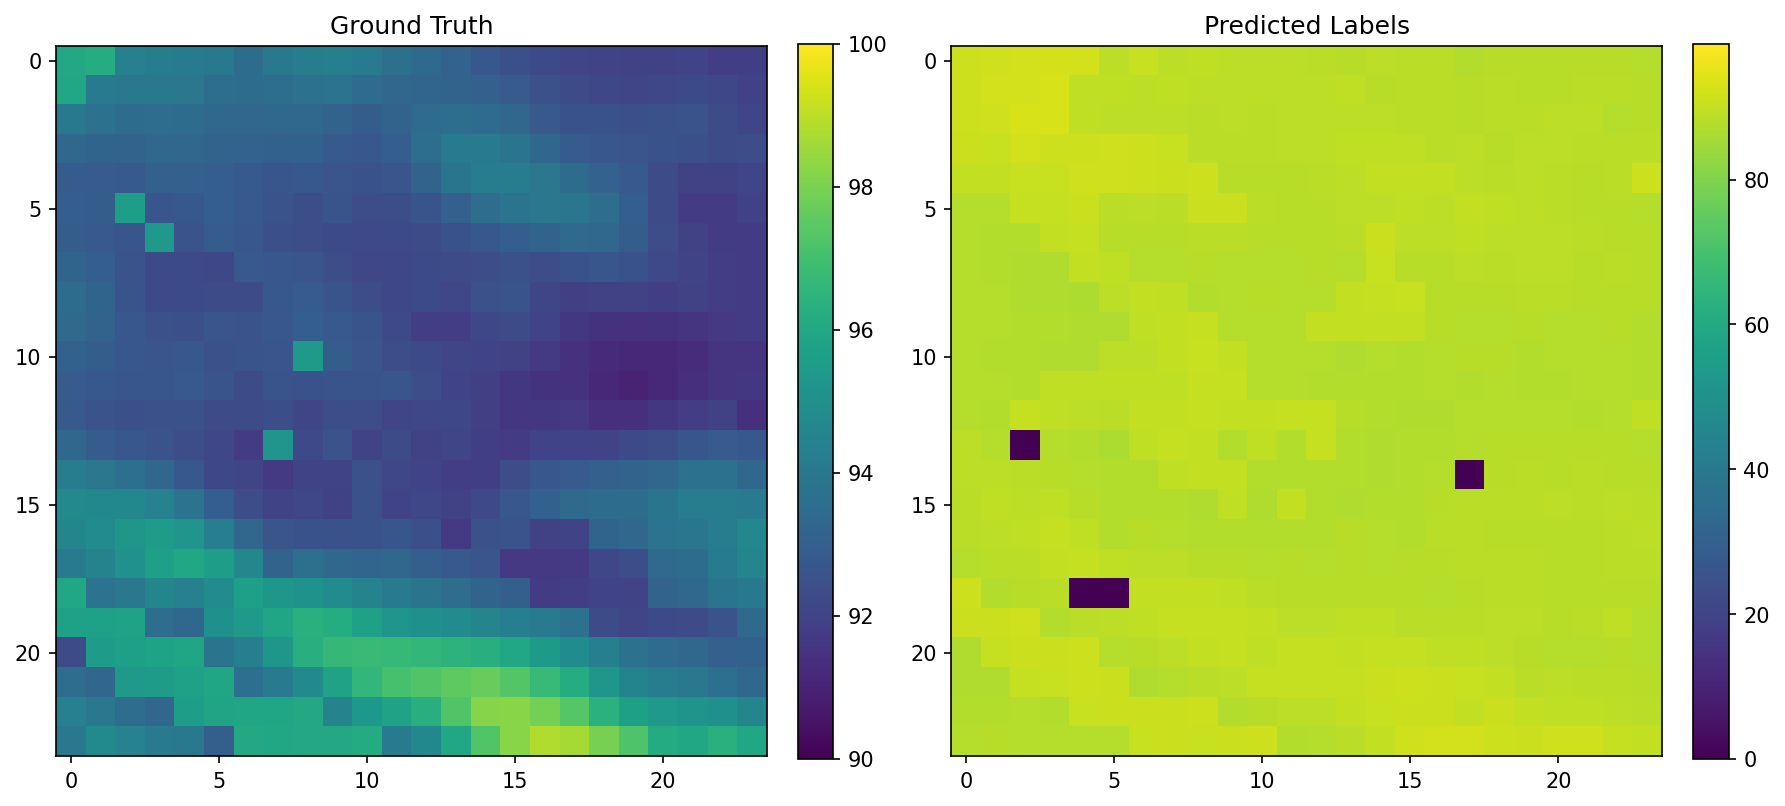

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from the validation set
predictions = model._model.predict(val_ds)  # Use the underlying Keras model

# Assuming the structure of val_ds returns (input_data, ground_truth)
for input_data, ground_truth in val_ds.take(1):  # Taking just one batch from val_ds
    # Get predicted labels
    predicted_labels = model._model.predict(input_data)
    
    # Compute shared vmin and vmax for consistent color range
    vmin = min(
        np.min(ground_truth[:, 0, :, :, 0]), 
        np.min(predicted_labels[:, 0, :, :, 0])
    )
    vmax = max(
        np.max(ground_truth[:, 0, :, :, 0]), 
        np.max(predicted_labels[:, 0, :, :, 0])
    )
    
    # Visualize the first sample
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=150)  # Higher DPI for quality
    
    # Ground Truth Visualization
    img1 = axes[0].imshow(
        ground_truth[0, 0, :, :, 0], 
        cmap='viridis', 
        vmin=90, 
        vmax=100
    )
    axes[0].set_title('Ground Truth')
    plt.colorbar(img1, ax=axes[0], fraction=0.046, pad=0.04)

    # Prediction Visualization
    img2 = axes[1].imshow(
        predicted_labels[0, 0, :, :, 0], 
        cmap='viridis', 
        vmin=vmin, 
        vmax=vmax
    )
    axes[1].set_title('Predicted Labels')
    plt.colorbar(img2, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    break  # Break after visualizing one batch


In [ ]:
from tensorflow.keras.models import load_model
model._model.save("saved_model/atmo_model2", save_format="tf")
loaded_model = load_model("saved_model/atmo_model")

In [ ]:
inputs, labels = next(iter(train_ds))
{key: tensor.shape for key, tensor in inputs.items()}

In [ ]:
model._model.summary()

In [ ]:
# Test calling the model on some training data
inputs, labels = next(iter(train_ds))
prediction = model.call(inputs)
print("Prediction shape:", prediction.shape)